In [1]:
!pip install seaborn

In [2]:
!pip install lightgbm

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, mutual_info_regression,chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import scipy.stats as stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


# EDA Installments Payments

In [4]:
installment_payments = pd.read_csv('/kaggle/input/home-credit-default-risk/installments_payments.csv')
pd.set_option('display.max_columns', None)

- SK_ID_PREV: ID dari kredit sebelumnya dalam HOME CREDIT terkait dengan pinjaman. Ini adalah identifikasi unik yang digunakan untuk menghubungkan kredit sebelumnya dengan pinjaman saat ini.

- SK_ID_CURR: Kolom identitas

- NUM_INSTALMENT_VERSION: Versi kalender angsuran (0 untuk kartu kredit) dari kredit sebelumnya. Perubahan versi angsuran dari bulan ke bulan menandakan bahwa beberapa parameter kalender pembayaran telah berubah.

- NUM_INSTALMENT_NUMBER: Urutan angsuran ke sekian. Ini menunjukkan urutan angsuran pada kredit sebelumnya.

- DAYS_INSTALMENT: Kapan angsuran dari kredit sebelumnya seharusnya dibayar (relatif terhadap tanggal aplikasi pinjaman saat ini). Nilai ini menunjukkan jumlah hari antara tanggal aplikasi pinjaman saat ini dengan tanggal jatuh tempo angsuran kredit sebelumnya.

- DAYS_ENTRY_PAYMENT: Kapan angsuran dari kredit sebelumnya benar-benar dibayar (relatif terhadap tanggal aplikasi pinjaman saat ini). Nilai ini menunjukkan jumlah hari antara tanggal aplikasi pinjaman saat ini dengan tanggal pembayaran sebenarnya untuk angsuran kredit sebelumnya.

- AMT_INSTALMENT: Jumlah angsuran yang ditetapkan dari kredit sebelumnya pada angsuran ini. Ini adalah jumlah yang diharapkan untuk dibayar oleh peminjam pada angsuran kredit sebelumnya.

- AMT_PAYMENT: Jumlah yang sebenarnya dibayar oleh klien pada kredit sebelumnya pada angsuran ini. Ini adalah jumlah yang benar-benar dibayarkan oleh peminjam untuk angsuran kredit sebelumnya.

In [5]:
import pandas as pd

# Baca dataset installment_payments.csv
installment_payments = pd.read_csv('/kaggle/input/home-credit-default-risk/installments_payments.csv')
installment_payments = installment_payments.fillna(0).abs()

# Agregat untuk 2, 3, 5 pembayaran terakhir
installment_agg_last2 = installment_payments.groupby('SK_ID_CURR').tail(2).groupby('SK_ID_CURR').agg({'NUM_INSTALMENT_VERSION': 'mean', 'DAYS_INSTALMENT': 'max', 'DAYS_ENTRY_PAYMENT': 'max', 'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()
installment_agg_last3 = installment_payments.groupby('SK_ID_CURR').tail(3).groupby('SK_ID_CURR').agg({'NUM_INSTALMENT_VERSION': 'mean', 'DAYS_INSTALMENT': 'max', 'DAYS_ENTRY_PAYMENT': 'max', 'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()


installment_agg_last5 = installment_payments.groupby('SK_ID_CURR').tail(5).groupby('SK_ID_CURR').agg({'NUM_INSTALMENT_VERSION': 'mean', 
                                                                                                      'DAYS_INSTALMENT': 'max', 'DAYS_ENTRY_PAYMENT': 'max', 'AMT_INSTALMENT': 'sum', 
                                                                                                      'AMT_PAYMENT': 'sum'}).reset_index()

# Agregat berdasarkan NUM_INSTALMENT_NUMBER pada 1, 2, 3, 4 pembayaran
installment_agg_num1 = installment_payments[installment_payments['NUM_INSTALMENT_NUMBER'] == 1].groupby('SK_ID_CURR').agg({'NUM_INSTALMENT_VERSION': 'mean', 'DAYS_INSTALMENT': 'max', 'DAYS_ENTRY_PAYMENT': 'max', 'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()
installment_agg_num2 = installment_payments[installment_payments['NUM_INSTALMENT_NUMBER'] == 2].groupby('SK_ID_CURR').agg({'NUM_INSTALMENT_VERSION': 'mean', 'DAYS_INSTALMENT': 'max', 'DAYS_ENTRY_PAYMENT': 'max', 'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()
installment_agg_num3 = installment_payments[installment_payments['NUM_INSTALMENT_NUMBER'] == 3].groupby('SK_ID_CURR').agg({'NUM_INSTALMENT_VERSION': 'mean', 'DAYS_INSTALMENT': 'max', 'DAYS_ENTRY_PAYMENT': 'max', 'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()
installment_agg_num4 = installment_payments[installment_payments['NUM_INSTALMENT_NUMBER'] == 4].groupby('SK_ID_CURR').agg({'NUM_INSTALMENT_VERSION': 'mean', 'DAYS_INSTALMENT': 'max', 'DAYS_ENTRY_PAYMENT': 'max', 'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()

# Agregat untuk 60, 90, 180, dan 365 hari terakhir berdasarkan DAYS_INSTALMENT
installment_agg_60days = installment_payments[installment_payments['DAYS_INSTALMENT'] >= -60].groupby('SK_ID_CURR').agg({'NUM_INSTALMENT_VERSION': 'mean', 'DAYS_INSTALMENT': 'max', 'DAYS_ENTRY_PAYMENT': 'max', 'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()
installment_agg_90days = installment_payments[installment_payments['DAYS_INSTALMENT'] >= -90].groupby('SK_ID_CURR').agg({'NUM_INSTALMENT_VERSION': 'mean', 'DAYS_INSTALMENT': 'max', 'DAYS_ENTRY_PAYMENT': 'max', 'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()
installment_agg_180days = installment_payments[installment_payments['DAYS_INSTALMENT'] >= -180].groupby('SK_ID_CURR').agg({'NUM_INSTALMENT_VERSION': 'mean', 'DAYS_INSTALMENT': 'max', 'DAYS_ENTRY_PAYMENT': 'max', 'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()
installment_agg_365days = installment_payments[installment_payments['DAYS_INSTALMENT'] >= -365].groupby('SK_ID_CURR').agg({'NUM_INSTALMENT_VERSION': 'mean', 'DAYS_INSTALMENT': 'max', 'DAYS_ENTRY_PAYMENT': 'max', 'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()

# Agregat untuk pembayaran yang melewati batas waktu (past due)
installment_payments['PAST_DUE'] = (installment_payments['DAYS_ENTRY_PAYMENT'] - installment_payments['DAYS_INSTALMENT']).apply(lambda x: 1 if x < 0 else 0)
installment_agg_pastdue = installment_payments.groupby('SK_ID_CURR').agg({'PAST_DUE': 'sum'}).reset_index()

# Gabungkan semua agregat menjadi satu DataFrame berdasarkan SK_ID_CURR
installment_features = pd.concat([installment_agg_last2, installment_agg_last3, installment_agg_last5,
                                 installment_agg_num1, installment_agg_num2, installment_agg_num3, installment_agg_num4,
                                 installment_agg_60days, installment_agg_90days, installment_agg_180days, installment_agg_365days,
                                 installment_agg_pastdue], axis=1)
installment_agg_num = pd.concat([installment_agg_num1, installment_agg_num2, installment_agg_num3, installment_agg_num4],axis=1)
installment_agg_last = pd.concat([installment_agg_last2, installment_agg_last3, installment_agg_last5],axis=1)
installment_agg_days = pd.concat([installment_agg_60days, installment_agg_90days, installment_agg_180days, installment_agg_365days],axis=1)

In [6]:
installment_agg_last5.head()

,SK_ID_CURR,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,100001,1.200000,2886.0,2875.0,33262.875,33262.875
1,100002,1.000000,475.0,498.0,46258.875,46258.875
2,100003,1.000000,2310.0,2324.0,216925.920,216925.920
3,100004,1.333333,784.0,795.0,21288.465,21288.465
4,100005,1.000000,676.0,711.0,24066.000,24066.000


## Company Losses

In [7]:
installment_agg_last2.count()

SK_ID_CURR                339587
NUM_INSTALMENT_VERSION    339587
DAYS_INSTALMENT           339587
DAYS_ENTRY_PAYMENT        339587
AMT_INSTALMENT            339587
AMT_PAYMENT               339587
dtype: int64

In [8]:
(installment_agg_last2[installment_agg_last2['DAYS_ENTRY_PAYMENT']==0].count())['DAYS_ENTRY_PAYMENT']

405

Terdapat 405 Pelanggan mengalami gagal bayar dalam 2 bulan terakhir

In [9]:
installment_agg_last3[installment_agg_last3['DAYS_ENTRY_PAYMENT']==0].count()

SK_ID_CURR                275
NUM_INSTALMENT_VERSION    275
DAYS_INSTALMENT           275
DAYS_ENTRY_PAYMENT        275
AMT_INSTALMENT            275
AMT_PAYMENT               275
dtype: int64

Terdapat 275 Pelanggan mengalami gagal bayar dalam 3 bulan terakhir

In [10]:
installment_agg_last5[installment_agg_last5['DAYS_ENTRY_PAYMENT']==0].count()

SK_ID_CURR                57
NUM_INSTALMENT_VERSION    57
DAYS_INSTALMENT           57
DAYS_ENTRY_PAYMENT        57
AMT_INSTALMENT            57
AMT_PAYMENT               57
dtype: int64

Terdapat 57 pelanggan mengalami gagal bayar dalam 5 bulan terakhir

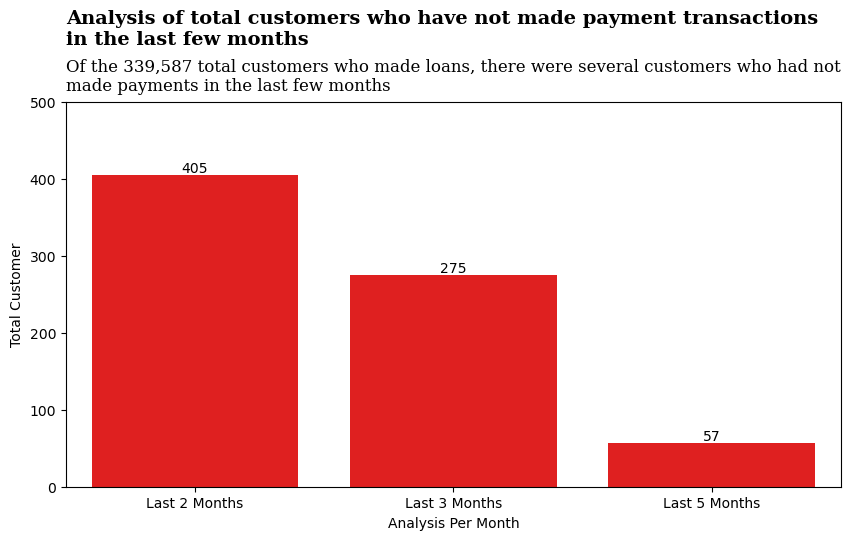

In [11]:
count = [(installment_agg_last2[installment_agg_last2['DAYS_ENTRY_PAYMENT']==0].count())['DAYS_ENTRY_PAYMENT'],
        (installment_agg_last3[installment_agg_last3['DAYS_ENTRY_PAYMENT']==0].count())['DAYS_ENTRY_PAYMENT'],
        (installment_agg_last5[installment_agg_last5['DAYS_ENTRY_PAYMENT']==0].count())['DAYS_ENTRY_PAYMENT']]
month = ['Last 2 Months','Last 3 Months','Last 5 Months']

plt.figure(figsize=(10,5))
g = sns.barplot(x=month, y=count, color='red')
plt.bar_label(g.containers[0])
plt.ylim(0,500)
plt.xlabel('Analysis Per Month')
plt.ylabel('Total Customer')
plt.text(0, 1.15, 'Analysis of total customers who have not made payment transactions\nin the last few months', ha='left',fontfamily='serif', fontsize=14, transform=plt.gca().transAxes, fontweight='bold')
plt.text(0, 1.03, 'Of the 339,587 total customers who made loans, there were several customers who had not\nmade payments in the last few months', ha='left',fontfamily='serif', fontsize=12, transform=plt.gca().transAxes)
plt.show()

In [12]:
total_unpaid = installment_payments[installment_payments['DAYS_ENTRY_PAYMENT']==0].agg({'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()
total_unpaid

,index,0
0,AMT_INSTALMENT,47322631.35
1,AMT_PAYMENT,0.00


Total kerugian akibat customer tidak membayar sebesar $47322631.35 

In [13]:
total_unpaid_1month = installment_payments[installment_payments['DAYS_ENTRY_PAYMENT']==0].tail(1).agg({'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()
total_unpaid_1month

,index,0
0,AMT_INSTALMENT,11504.25
1,AMT_PAYMENT,0.00


Total kerugian akibat customer tidak membayar tagihan pada 1 bulan terakhir sebesar $11504.25

## Total customers who are late paying bills

In [14]:
installment_agg_pastdue.agg({'PAST_DUE':'sum'})

PAST_DUE    1149574
dtype: int64

Terdapat keterlambatan pembayaran sebanyak 1149574 dari semua perlanggan yang melakukan peminjaman

In [15]:
late_1month = installment_payments.groupby('SK_ID_CURR').tail(1).groupby('SK_ID_CURR').agg({'NUM_INSTALMENT_VERSION': 'mean', 'DAYS_INSTALMENT': 'max', 'DAYS_ENTRY_PAYMENT': 'max', 'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()
late_1month['PAST_DUE'] = (late_1month['DAYS_ENTRY_PAYMENT'] - late_1month['DAYS_INSTALMENT']).apply(lambda x: 1 if x < 0 else 0)
total_late_1month = late_1month.agg({'PAST_DUE': 'sum'}).reset_index()
total_late_1month

,index,0
0,PAST_DUE,26450


Terdapat 26450 pelanggan yang terlambat melakukan pembayaran tagihan dalam 1 bulan terakhir

# EDA credit_balance

In [16]:
import pandas as pd
credit_card_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/credit_card_balance.csv')

In [17]:
credit_card_balance.fillna(0)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.00,1800.000,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.00,2250.000,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.00,2250.000,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.00,11925.000,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.00,27000.000,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,0.00,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,1879.11,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,375750.00,356994.675,269356.140,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,0.0,0.0,0.0,0.0,0.000,0.00,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,0.0,Active,0,0


In [18]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [19]:
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.00,1800.000,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.00,2250.000,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.00,2250.000,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.00,11925.000,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.00,27000.000,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,1879.11,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,375750.00,356994.675,269356.140,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [20]:
credit_card_balance['max_current'] = credit_card_balance['AMT_BALANCE'] + credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL']
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,max_current
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.00,1800.000,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0,135056.970
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.00,2250.000,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0,108975.555
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.00,2250.000,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0,481815.225
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.00,11925.000,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0,461572.110
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.00,27000.000,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0,903919.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0,45000.000
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,1879.11,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0,45000.000
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,375750.00,356994.675,269356.140,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0,860784.975
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0,450000.000


In [21]:
pd.set_option('display.max_columns', None)
x = ['SK_ID_PREV','SK_ID_CURR','MONTHS_BALANCE','CNT_INSTALMENT_MATURE_CUM','AMT_BALANCE',
     'AMT_CREDIT_LIMIT_ACTUAL','max_current','AMT_INST_MIN_REGULARITY','AMT_PAYMENT_TOTAL_CURRENT',
                                       'AMT_TOTAL_RECEIVABLE','CNT_DRAWINGS_CURRENT','SK_DPD','SK_DPD_DEF']
credit_card_balance = credit_card_balance[x]

In [22]:
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT_MATURE_CUM,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,max_current,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,35.0,56.970,135000,135056.970,1700.325,1800.000,0.000,1,0,0
1,2582071,363914,-1,69.0,63975.555,45000,108975.555,2250.000,2250.000,64875.555,1,0,0
2,1740877,371185,-7,30.0,31815.225,450000,481815.225,2250.000,2250.000,31460.085,0,0,0
3,1389973,337855,-4,10.0,236572.110,225000,461572.110,11795.760,11925.000,233048.970,1,0,0
4,1891521,126868,-1,101.0,453919.455,450000,903919.455,22924.890,27000.000,453919.455,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.0,0.000,45000,45000.000,0.000,0.000,0.000,0,0,0
3840308,1714892,347207,-9,23.0,0.000,45000,45000.000,0.000,0.000,0.000,0,0,0
3840309,1302323,215757,-9,18.0,275784.975,585000,860784.975,2250.000,356994.675,273093.975,2,0,0
3840310,1624872,430337,-10,0.0,0.000,450000,450000.000,0.000,0.000,0.000,0,0,0


In [23]:
credit_card_balance[credit_card_balance['SK_ID_CURR']==378907].sort_values(by='MONTHS_BALANCE').tail(1)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT_MATURE_CUM,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,max_current,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,SK_DPD,SK_DPD_DEF
330701,2562384,378907,-2,39.0,28.575,9000,9028.575,1916.91,1916.91,28.575,0,0,0


In [24]:
credit_card_balance_agg = credit_card_balance.groupby('SK_ID_CURR').tail(1).groupby('SK_ID_CURR').agg({'MONTHS_BALANCE': 'min','CNT_INSTALMENT_MATURE_CUM':'max',})

In [25]:
sorted_data = credit_card_balance.sort_values('MONTHS_BALANCE')

# Group by 'SK_ID_CURR' and calculate minimum 'MONTHS_BALANCE' and maximum 'CNT_INSTALMENT_MATURE_CUM'
grouped_data = sorted_data.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': 'min',
    'CNT_INSTALMENT_MATURE_CUM': 'max'
})

# Get the last row for each group based on the sorted order
last_row_indices = sorted_data.groupby('SK_ID_CURR').tail(1).index
# Get the last values for other columns based on the last row indices
last_values = sorted_data.loc[last_row_indices]
# Merge the grouped data and last values
credit_card_balance_agg = pd.merge(grouped_data, last_values, on='SK_ID_CURR').abs()

In [26]:
drop = ['MONTHS_BALANCE_y','CNT_INSTALMENT_MATURE_CUM_y']
credit_card_balance_agg = credit_card_balance_agg.drop(drop, axis=1)

In [27]:
credit_card_balance_agg[credit_card_balance_agg['SK_ID_CURR']==378907]


,SK_ID_CURR,MONTHS_BALANCE_x,CNT_INSTALMENT_MATURE_CUM_x,SK_ID_PREV,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,max_current,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,SK_DPD,SK_DPD_DEF
81043,378907,48,39.0,2562384,28.575,9000,9028.575,1916.91,1916.91,28.575,0,0,0


In [28]:
credit_card_balance_agg['unpaid_invoice_amount'] = credit_card_balance_agg['AMT_TOTAL_RECEIVABLE'] - credit_card_balance_agg['AMT_PAYMENT_TOTAL_CURRENT']

In [29]:
credit_card_balance_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103558 entries, 0 to 103557
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   103558 non-null  int64  
 1   MONTHS_BALANCE_x             103558 non-null  int64  
 2   CNT_INSTALMENT_MATURE_CUM_x  103558 non-null  float64
 3   SK_ID_PREV                   103558 non-null  int64  
 4   AMT_BALANCE                  103558 non-null  float64
 5   AMT_CREDIT_LIMIT_ACTUAL      103558 non-null  int64  
 6   max_current                  103558 non-null  float64
 7   AMT_INST_MIN_REGULARITY      103558 non-null  float64
 8   AMT_PAYMENT_TOTAL_CURRENT    103558 non-null  float64
 9   AMT_TOTAL_RECEIVABLE         103558 non-null  float64
 10  CNT_DRAWINGS_CURRENT         103558 non-null  int64  
 11  SK_DPD                       103558 non-null  int64  
 12  SK_DPD_DEF                   103558 non-null  int64  
 13 

## The Amount of Customer Income is Smaller Than Income

In [30]:
credit_card_balance_agg['unpaid_invoice_amount'].count()

103558

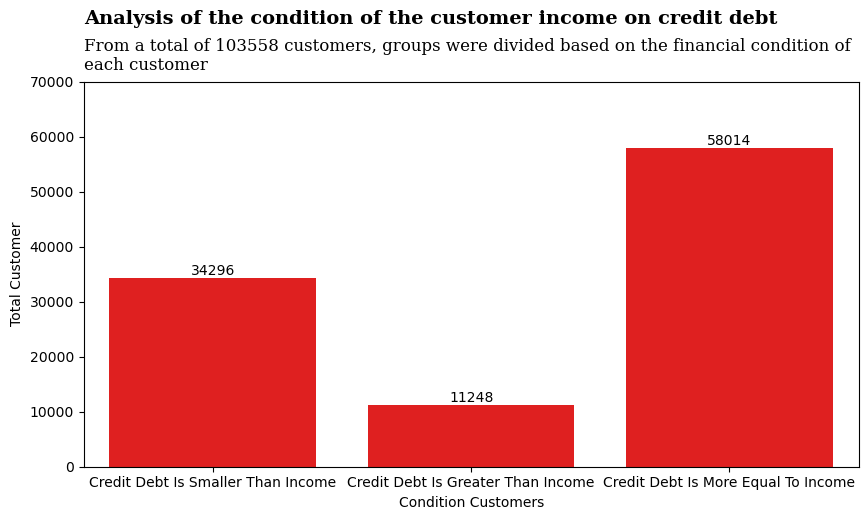

In [31]:
Income_Condition = [((credit_card_balance_agg[credit_card_balance_agg['unpaid_invoice_amount']>0].count())['unpaid_invoice_amount']),
                              ((credit_card_balance_agg[credit_card_balance_agg['unpaid_invoice_amount']<0].count())['unpaid_invoice_amount']),
                             ((credit_card_balance_agg[credit_card_balance_agg['unpaid_invoice_amount']==0].count())['unpaid_invoice_amount'])]
Income_Condition_Obj = ['Credit Debt Is Smaller Than Income','Credit Debt Is Greater Than Income','Credit Debt Is More Equal To Income']

plt.figure(figsize=(10,5))
g = sns.barplot(x=Income_Condition_Obj, y=Income_Condition, color='red')
plt.bar_label(g.containers[0])
plt.ylim(0,70000)
plt.xlabel('Condition Customers')
plt.ylabel('Total Customer')
plt.text(0, 1.15, 'Analysis of the condition of the customer income on credit debt', ha='left',fontfamily='serif', fontsize=14, transform=plt.gca().transAxes, fontweight='bold')
plt.text(0, 1.03, 'From a total of 103558 customers, groups were divided based on the financial condition of\neach customer', ha='left',fontfamily='serif', fontsize=12, transform=plt.gca().transAxes)
plt.show()

Terdapat **11248 custome**r yang pengeluarannya lebih besar dari pemasukannya

# EDA POSH_CASH_BALANCE

In [32]:
import pandas as pd
POS_CASH_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv')

In [33]:
POS_CASH_balance[POS_CASH_balance['SK_ID_CURR']==378907].sort_values(by='CNT_INSTALMENT_FUTURE')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
9888656,1095902,378907,-11,24.0,0.0,Completed,0,0
7560974,2150399,378907,-28,24.0,0.0,Active,0,0
7222268,2150399,378907,-27,24.0,0.0,Completed,0,0
8560016,1095902,378907,-12,24.0,0.0,Active,0,0
9889236,1095902,378907,-13,24.0,1.0,Active,0,0
8269580,2150399,378907,-29,24.0,1.0,Active,0,0
9888237,1095902,378907,-14,24.0,2.0,Active,0,0
7562109,2150399,378907,-30,24.0,2.0,Active,0,0
8268844,2150399,378907,-31,24.0,3.0,Active,0,0
9795046,1095902,378907,-15,24.0,3.0,Active,5,5


In [34]:
POS_CASH_balance_agg = POS_CASH_balance.groupby(['SK_ID_CURR']).agg({'SK_DPD': 'sum','SK_DPD_DEF':'sum',}).reset_index()
POS_CASH_balance_agg['DIF_SK_DPD_SK_DPD_DEF'] = POS_CASH_balance_agg['SK_DPD'] - POS_CASH_balance_agg['SK_DPD_DEF']

In [35]:
POS_CASH_balance_agg[POS_CASH_balance_agg['DIF_SK_DPD_SK_DPD_DEF']!=0].count()

SK_ID_CURR               25347
SK_DPD                   25347
SK_DPD_DEF               25347
DIF_SK_DPD_SK_DPD_DEF    25347
dtype: int64

In [36]:
POS_CASH_balance_agg[POS_CASH_balance_agg['DIF_SK_DPD_SK_DPD_DEF']==0]

,SK_ID_CURR,SK_DPD,SK_DPD_DEF,DIF_SK_DPD_SK_DPD_DEF
0,100001,7,7,0
1,100002,0,0,0
2,100003,0,0,0
3,100004,0,0,0
4,100005,0,0,0
...,...,...,...,...
337247,456251,0,0,0
337248,456252,0,0,0
337249,456253,5,5,0
337250,456254,0,0,0


## Menghitung pelanggan yang membayar melebihi waktu toleransi/ tidak mendapat toleransi

In [37]:
POS_CASH_balance_agg['DIF_SK_DPD_SK_DPD_DEF'].count()

337252

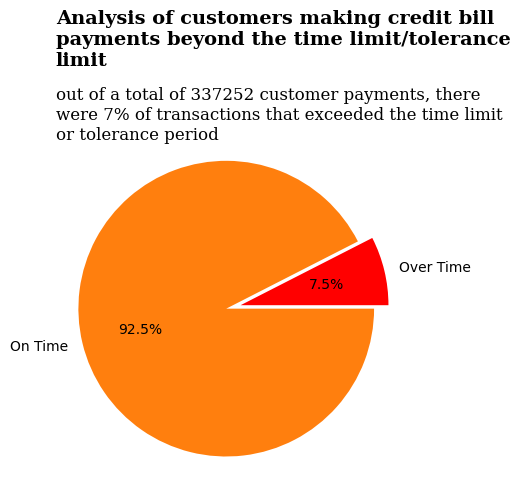

In [38]:
over_time = [(POS_CASH_balance_agg[POS_CASH_balance_agg['DIF_SK_DPD_SK_DPD_DEF']>0].count())['DIF_SK_DPD_SK_DPD_DEF'],(POS_CASH_balance_agg[POS_CASH_balance_agg['DIF_SK_DPD_SK_DPD_DEF']==0].count())['DIF_SK_DPD_SK_DPD_DEF']]
over_time_obj = ['Over Time', 'On Time']

plt.text(0, 1.15, 'Analysis of customers making credit bill \npayments beyond the time limit/tolerance\nlimit', ha='left',fontfamily='serif', fontsize=14, transform=plt.gca().transAxes, fontweight='bold')
plt.text(0, 0.95, 'out of a total of 337252 customer payments, there\nwere 7% of transactions that exceeded the time limit\nor tolerance period', ha='left',fontfamily='serif', fontsize=12, transform=plt.gca().transAxes)
explode = (0,0.1)
plt.pie(over_time,labels = over_time_obj,autopct='%1.1f%%', explode = explode, colors = ['red','tab:orange'])
plt.show()

Sebanyak **25347** pelanggan melewati batas pembayaran yang ditentukan

# EDA previous_application

In [39]:
import pandas as pd
previous_application = pd.read_csv('/kaggle/input/home-credit-default-risk/previous_application.csv')

In [40]:
previous_application[previous_application['SK_ID_CURR']==215354]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
139772,1130982,215354,Consumer loans,25817.895,150043.5,140827.5,15007.5,150043.5,FRIDAY,11,Y,1,0.104884,NaN,NaN,XAP,Approved,-346,Cash through the bank,XAP,NaN,Repeater,Jewelry,POS,XNA,Stone,50,Industry,6.0,middle,POS other with interest,365243.0,-314.0,-164.0,-194.0,-190.0,0.0
528263,1927804,215354,Consumer loans,12750.750,337500.0,337500.0,0.0,337500.0,TUESDAY,18,Y,1,0.000000,NaN,NaN,XAP,Approved,-265,Cash through the bank,XAP,NaN,Repeater,Medicine,POS,XNA,Stone,25,Industry,36.0,low_normal,POS other with interest,365243.0,-233.0,817.0,365243.0,365243.0,0.0
701139,2829838,215354,Cash loans,51081.750,1125000.0,1125000.0,NaN,1125000.0,SATURDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-919,Cash through the bank,XAP,Unaccompanied,Refreshed,XNA,Cash,x-sell,AP+ (Cash loan),39,XNA,48.0,middle,Cash X-Sell: middle,365243.0,-887.0,523.0,365243.0,365243.0,0.0
1318169,1362380,215354,Consumer loans,5384.295,35955.0,34492.5,3600.0,35955.0,FRIDAY,9,Y,1,0.102926,NaN,NaN,XAP,Approved,-2579,Cash through the bank,XAP,Unaccompanied,New,Other,POS,XNA,Country-wide,613,Consumer electronics,8.0,high,POS household with interest,365243.0,-2548.0,-2338.0,-2338.0,-2332.0,1.0
1334969,2340808,215354,Revolving loans,22500.000,0.0,450000.0,NaN,NaN,SATURDAY,11,Y,1,NaN,NaN,NaN,XAP,Approved,-919,XNA,XAP,NaN,Refreshed,XNA,Cards,x-sell,AP+ (Cash loan),39,XNA,0.0,XNA,Card X-Sell,-887.0,-845.0,365243.0,365243.0,365243.0,0.0


In [41]:
previous_application.sort_values(['SK_ID_CURR', 'SK_ID_PREV'], inplace=True)

In [42]:
previous_application[previous_application['SK_ID_CURR']==215354]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
139772,1130982,215354,Consumer loans,25817.895,150043.5,140827.5,15007.5,150043.5,FRIDAY,11,Y,1,0.104884,NaN,NaN,XAP,Approved,-346,Cash through the bank,XAP,NaN,Repeater,Jewelry,POS,XNA,Stone,50,Industry,6.0,middle,POS other with interest,365243.0,-314.0,-164.0,-194.0,-190.0,0.0
1318169,1362380,215354,Consumer loans,5384.295,35955.0,34492.5,3600.0,35955.0,FRIDAY,9,Y,1,0.102926,NaN,NaN,XAP,Approved,-2579,Cash through the bank,XAP,Unaccompanied,New,Other,POS,XNA,Country-wide,613,Consumer electronics,8.0,high,POS household with interest,365243.0,-2548.0,-2338.0,-2338.0,-2332.0,1.0
528263,1927804,215354,Consumer loans,12750.750,337500.0,337500.0,0.0,337500.0,TUESDAY,18,Y,1,0.000000,NaN,NaN,XAP,Approved,-265,Cash through the bank,XAP,NaN,Repeater,Medicine,POS,XNA,Stone,25,Industry,36.0,low_normal,POS other with interest,365243.0,-233.0,817.0,365243.0,365243.0,0.0
1334969,2340808,215354,Revolving loans,22500.000,0.0,450000.0,NaN,NaN,SATURDAY,11,Y,1,NaN,NaN,NaN,XAP,Approved,-919,XNA,XAP,NaN,Refreshed,XNA,Cards,x-sell,AP+ (Cash loan),39,XNA,0.0,XNA,Card X-Sell,-887.0,-845.0,365243.0,365243.0,365243.0,0.0
701139,2829838,215354,Cash loans,51081.750,1125000.0,1125000.0,NaN,1125000.0,SATURDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-919,Cash through the bank,XAP,Unaccompanied,Refreshed,XNA,Cash,x-sell,AP+ (Cash loan),39,XNA,48.0,middle,Cash X-Sell: middle,365243.0,-887.0,523.0,365243.0,365243.0,0.0


In [43]:
previous_application['PREV_COUNT'] = previous_application.groupby('SK_ID_CURR').cumcount() + 1

In [44]:
previous_application[previous_application['SK_ID_CURR']==215354]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,PREV_COUNT
139772,1130982,215354,Consumer loans,25817.895,150043.5,140827.5,15007.5,150043.5,FRIDAY,11,Y,1,0.104884,NaN,NaN,XAP,Approved,-346,Cash through the bank,XAP,NaN,Repeater,Jewelry,POS,XNA,Stone,50,Industry,6.0,middle,POS other with interest,365243.0,-314.0,-164.0,-194.0,-190.0,0.0,1
1318169,1362380,215354,Consumer loans,5384.295,35955.0,34492.5,3600.0,35955.0,FRIDAY,9,Y,1,0.102926,NaN,NaN,XAP,Approved,-2579,Cash through the bank,XAP,Unaccompanied,New,Other,POS,XNA,Country-wide,613,Consumer electronics,8.0,high,POS household with interest,365243.0,-2548.0,-2338.0,-2338.0,-2332.0,1.0,2
528263,1927804,215354,Consumer loans,12750.750,337500.0,337500.0,0.0,337500.0,TUESDAY,18,Y,1,0.000000,NaN,NaN,XAP,Approved,-265,Cash through the bank,XAP,NaN,Repeater,Medicine,POS,XNA,Stone,25,Industry,36.0,low_normal,POS other with interest,365243.0,-233.0,817.0,365243.0,365243.0,0.0,3
1334969,2340808,215354,Revolving loans,22500.000,0.0,450000.0,NaN,NaN,SATURDAY,11,Y,1,NaN,NaN,NaN,XAP,Approved,-919,XNA,XAP,NaN,Refreshed,XNA,Cards,x-sell,AP+ (Cash loan),39,XNA,0.0,XNA,Card X-Sell,-887.0,-845.0,365243.0,365243.0,365243.0,0.0,4
701139,2829838,215354,Cash loans,51081.750,1125000.0,1125000.0,NaN,1125000.0,SATURDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-919,Cash through the bank,XAP,Unaccompanied,Refreshed,XNA,Cash,x-sell,AP+ (Cash loan),39,XNA,48.0,middle,Cash X-Sell: middle,365243.0,-887.0,523.0,365243.0,365243.0,0.0,5


In [45]:
# Menggabungkan data untuk 3 aplikasi terakhir
df_last_3 = previous_application[previous_application['PREV_COUNT'] <= 3].groupby('SK_ID_CURR').agg({
    'AMT_ANNUITY': 'mean',
    'AMT_APPLICATION': 'sum',
    'AMT_CREDIT': 'sum',
    'NAME_CONTRACT_STATUS': lambda x: x.mode().iat[0]
}).reset_index()

# Menggabungkan data untuk 5 aplikasi terakhir
df_last_5 = previous_application[previous_application['PREV_COUNT'] <= 5].groupby('SK_ID_CURR').agg({
    'AMT_ANNUITY': 'mean',
    'AMT_APPLICATION': 'sum',
    'AMT_CREDIT': 'sum',
    'NAME_CONTRACT_STATUS': lambda x: x.mode().iat[0]
}).reset_index()

# Menggabungkan data untuk 2 aplikasi pertama
df_first_2 = previous_application[previous_application['PREV_COUNT'] <= 2].groupby('SK_ID_CURR').agg({
    'AMT_ANNUITY': 'mean',
    'AMT_APPLICATION': 'sum',
    'AMT_CREDIT': 'sum',
    'NAME_CONTRACT_STATUS': lambda x: x.mode().iat[0]
}).reset_index()

# Menggabungkan data untuk 4 aplikasi pertama
df_first_4 = previous_application[previous_application['PREV_COUNT'] <= 4].groupby('SK_ID_CURR').agg({
    'AMT_ANNUITY': 'mean',
    'AMT_APPLICATION': 'sum',
    'AMT_CREDIT': 'sum',
    'NAME_CONTRACT_STATUS': lambda x: x.mode().iat[0]
}).reset_index()

In [46]:
df_last_3

,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,NAME_CONTRACT_STATUS
0,100001,3951.0000,24835.5,23787.0,Approved
1,100002,9251.7750,179055.0,179055.0,Approved
2,100003,56553.9900,1306309.5,1452573.0,Approved
3,100004,5357.2500,24282.0,20106.0,Approved
4,100005,4813.2000,44617.5,40153.5,Approved
...,...,...,...,...,...
338852,456251,6605.9100,40455.0,40455.0,Approved
338853,456252,10074.4650,57595.5,56821.5,Approved
338854,456253,4770.4050,48325.5,41251.5,Approved
338855,456254,10681.1325,242635.5,268879.5,Approved


In [47]:
df_first_2[(df_first_2['AMT_APPLICATION']-df_first_2['AMT_CREDIT'])>0].count()

SK_ID_CURR              103936
AMT_ANNUITY             103936
AMT_APPLICATION         103936
AMT_CREDIT              103936
NAME_CONTRACT_STATUS    103936
dtype: int64

Terdapat 103936 pinjaman dari 2 pinjaman awal setiap customer yang nilai yang diberikan lebih kecil dari yang diajukan

In [48]:
df_first_4[(df_first_4['AMT_APPLICATION']-df_first_4['AMT_CREDIT'])>0].count()

SK_ID_CURR              96783
AMT_ANNUITY             96783
AMT_APPLICATION         96783
AMT_CREDIT              96783
NAME_CONTRACT_STATUS    96783
dtype: int64

Terdapat 96783 pinjaman dari 4 pinjaman awal setiap customer yang nilai yang diberikan lebih kecil dari yang diajukan

In [49]:
df_last_3[(df_last_3['AMT_APPLICATION']-df_last_3['AMT_CREDIT'])>0].count()

SK_ID_CURR              100373
AMT_ANNUITY             100373
AMT_APPLICATION         100373
AMT_CREDIT              100373
NAME_CONTRACT_STATUS    100373
dtype: int64

Terdapat 100373 pinjaman dari 3 pinjaman akhir setiap customer yang nilai yang diberikan lebih kecil dari yang diajukan

In [50]:
df_last_5['AMT_APPLICATION'].count()

338857

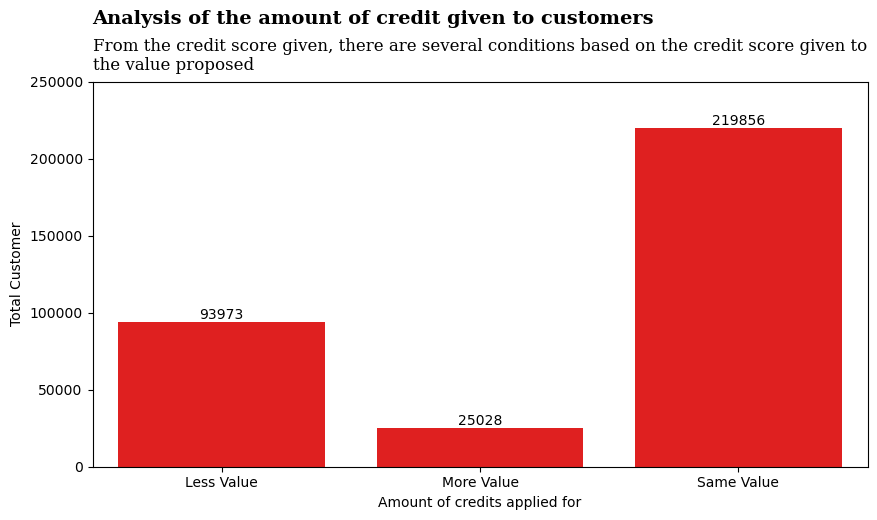

In [51]:
loan_application = [(df_last_5[(df_last_5['AMT_APPLICATION']-df_last_5['AMT_CREDIT'])>0].count())['AMT_APPLICATION'],
                   (df_last_5[(df_last_5['AMT_APPLICATION']-df_last_5['AMT_CREDIT'])==0].count())['AMT_APPLICATION'],
                   (df_last_5[(df_last_5['AMT_APPLICATION']-df_last_5['AMT_CREDIT'])<0].count())['AMT_APPLICATION']]
loan_application_obj = ['Less Value','More Value','Same Value']

plt.figure(figsize=(10,5))
g = sns.barplot(x=loan_application_obj, y=loan_application, color='red')
plt.bar_label(g.containers[0])
plt.ylim(0,250000)
plt.xlabel('Amount of credits applied for')
plt.ylabel('Total Customer')
plt.text(0, 1.15, 'Analysis of the amount of credit given to customers', ha='left',fontfamily='serif', fontsize=14, transform=plt.gca().transAxes, fontweight='bold')
plt.text(0, 1.03, 'From the credit score given, there are several conditions based on the credit score given to\nthe value proposed', ha='left',fontfamily='serif', fontsize=12, transform=plt.gca().transAxes)
plt.show()

Terdapat 93973 pinjaman dari 5 pinjaman akhir setiap customer yang nilai yang diberikan lebih kecil dari yang diajukan

# EDA  bureau

In [52]:
import pandas as pd
bureau = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')

In [53]:
pd.set_option('display.max_columns', None)
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [54]:
bureau[bureau['SK_ID_CURR']==405791].sort_values(by='SK_ID_BUREAU')

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
377886,405791,6008177,Closed,currency 1,-2754,0,NaN,-2565.0,NaN,0,9000000.0,0.0,0.0,0.0,Consumer credit,-1881,0.0
377887,405791,6008178,Closed,currency 1,-2340,0,-1918.0,-1159.0,NaN,0,1255500.0,NaN,NaN,0.0,Consumer credit,-1156,0.0
218508,405791,6008179,Active,currency 1,0,0,NaN,NaN,NaN,0,NaN,654993.0,NaN,0.0,Another type of loan,-5,NaN
218509,405791,6008180,Active,currency 1,-1928,0,1687.0,NaN,NaN,0,630000.0,328063.5,NaN,0.0,Credit card,-2,19800.0
218510,405791,6008181,Active,currency 1,-318,0,1508.0,NaN,81.0,0,4500000.0,NaN,NaN,0.0,Consumer credit,-14,119160.0
218511,405791,6008182,Active,currency 1,-660,0,10297.0,NaN,215770.5,0,3712500.0,NaN,NaN,0.0,Credit card,-15,174789.0
377888,405791,6008183,Closed,currency 1,-1018,0,808.0,-445.0,0.0,0,3226941.0,NaN,NaN,0.0,Car loan,-445,NaN
218512,405791,6008184,Closed,currency 1,-1487,0,4053.0,-1193.0,0.0,0,1800000.0,NaN,NaN,0.0,Mortgage,-1193,NaN
377889,405791,6008185,Closed,currency 1,-1766,0,60.0,-1033.0,0.0,0,2103660.0,NaN,NaN,0.0,Car loan,-1033,NaN


In [55]:
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
bureau['AMT_CREDIT_SUM'] = bureau['AMT_CREDIT_SUM'].fillna(bureau['AMT_CREDIT_SUM_DEBT'])
bureau_agg = bureau.groupby('SK_ID_CURR').agg({'AMT_CREDIT_SUM':'sum', 
                                               'AMT_CREDIT_SUM_DEBT':'sum',
                                               'DAYS_CREDIT_UPDATE':'max'}).reset_index()

In [56]:
bureau.isnull().sum()

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                  0
AMT_CREDIT_SUM_DEBT             0
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

In [57]:
bureau_agg

,SK_ID_CURR,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,DAYS_CREDIT_UPDATE
0,100001,1453365.000,596686.500,-6
1,100002,865055.565,245781.000,-7
2,100003,1017400.500,0.000,-43
3,100004,189037.800,0.000,-382
4,100005,657126.000,568408.500,-11
...,...,...,...,...
305806,456249,3693858.660,163071.000,-12
305807,456250,3086459.550,2232040.095,-23
305808,456253,3960000.000,1795833.000,-5
305809,456254,45000.000,0.000,-401


In [58]:
bureau_agg[bureau_agg['AMT_CREDIT_SUM_DEBT']==0].count()

SK_ID_CURR             89026
AMT_CREDIT_SUM         89026
AMT_CREDIT_SUM_DEBT    89026
DAYS_CREDIT_UPDATE     89026
dtype: int64

Terdapat 89026 customer yang tidak memiliki hutang credit

In [59]:
bureau_agg[bureau_agg['AMT_CREDIT_SUM_DEBT']!=0].count()

SK_ID_CURR             216785
AMT_CREDIT_SUM         216785
AMT_CREDIT_SUM_DEBT    216785
DAYS_CREDIT_UPDATE     216785
dtype: int64

Terdapat 216785 customer yang tidak memiliki hutang credit

In [60]:
import matplotlib.pyplot as plt

In [61]:
bureau_agg['AMT_CREDIT_SUM_DEBT'].count()

305811

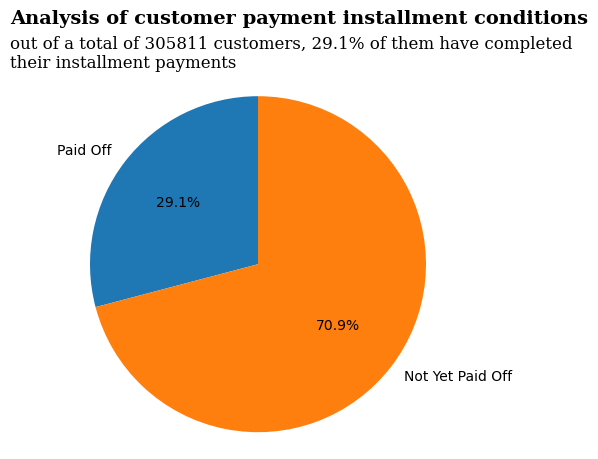

In [152]:
labels = ['Paid Off', 'Not Yet Paid Off']
sizes = [bureau_agg[bureau_agg['AMT_CREDIT_SUM_DEBT'] == 0].count()[0],
         bureau_agg[bureau_agg['AMT_CREDIT_SUM_DEBT'] != 0].count()[0]]

# Konfigurasi plot
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Pastikan lingkaran pie menjadi lingkaran, bukan elips
plt.text(0, 1.15, 'Analysis of customer payment installment conditions', ha='left',fontfamily='serif', fontsize=14, transform=plt.gca().transAxes, fontweight='bold')
plt.text(0, 1.03, 'out of a total of 305811 customers, 29.1% of them have completed\ntheir installment payments', ha='left',fontfamily='serif', fontsize=12, transform=plt.gca().transAxes)

plt.show()

# EDA application_train

In [63]:
import pandas as pd
application_train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')

In [64]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

_______________________________________________________________

In [65]:
pd.set_option('display.max_column', None)
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [66]:
pd.set_option('display.max_row',None)
print(application_train.nunique())
pd.reset_option('display.max_row')

SK_ID_CURR                      307511
TARGET                               2
NAME_CONTRACT_TYPE                   2
CODE_GENDER                          3
FLAG_OWN_CAR                         2
FLAG_OWN_REALTY                      2
CNT_CHILDREN                        15
AMT_INCOME_TOTAL                  2548
AMT_CREDIT                        5603
AMT_ANNUITY                      13672
AMT_GOODS_PRICE                   1002
NAME_TYPE_SUITE                      7
NAME_INCOME_TYPE                     8
NAME_EDUCATION_TYPE                  5
NAME_FAMILY_STATUS                   6
NAME_HOUSING_TYPE                    6
REGION_POPULATION_RELATIVE          81
DAYS_BIRTH                       17460
DAYS_EMPLOYED                    12574
DAYS_REGISTRATION                15688
DAYS_ID_PUBLISH                   6168
OWN_CAR_AGE                         62
FLAG_MOBIL                           2
FLAG_EMP_PHONE                       2
FLAG_WORK_PHONE                      2
FLAG_CONT_MOBILE         

In [67]:
# Daftar kolom numerik yang memiliki nilai unik sebanyak 2
kolom_numerik_ubah = []
for kolom in application_train.select_dtypes(include='number').columns:
    if application_train[kolom].nunique() == 2:
        kolom_numerik_ubah.append(kolom)

# Mengganti nilai 0 dengan 'N' dan nilai 1 dengan 'Y' pada kolom numerik terpilih
application_train[kolom_numerik_ubah] = application_train[kolom_numerik_ubah].replace({0: 'N', 1: 'Y'})

In [68]:
categorical_cols = []
for col in application_train.columns:
    if application_train[col].dtype == 'object' or application_train[col].dtype.name == 'category' or application_train[col].dtype == 'bool':
        categorical_cols.append(col)
cat = application_train[categorical_cols]

In [69]:
cat

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,Y,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Y,Y,N,Y,Y,N,Laborers,WEDNESDAY,N,N,N,N,N,N,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
1,N,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Y,Y,N,Y,Y,N,Core staff,MONDAY,N,N,N,N,N,N,School,reg oper account,block of flats,Block,No,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
2,N,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Y,Y,Y,Y,Y,N,Laborers,MONDAY,N,N,N,N,N,N,Government,NaN,NaN,NaN,NaN,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
3,N,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Y,Y,N,Y,N,N,Laborers,WEDNESDAY,N,N,N,N,N,N,Business Entity Type 3,NaN,NaN,NaN,NaN,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
4,N,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Y,Y,N,Y,N,N,Core staff,THURSDAY,N,N,N,N,Y,Y,Religion,NaN,NaN,NaN,NaN,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,N,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Y,Y,N,Y,N,N,Sales staff,THURSDAY,N,N,N,N,N,N,Services,reg oper account,block of flats,"Stone, brick",No,N,N,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N
307507,N,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,Y,N,N,Y,Y,N,NaN,MONDAY,N,N,N,N,N,N,XNA,reg oper account,block of flats,"Stone, brick",No,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
307508,N,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Y,Y,N,Y,N,Y,Managers,THURSDAY,N,N,N,N,Y,Y,School,reg oper account,block of flats,Panel,No,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
307509,Y,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Y,Y,N,Y,N,N,Laborers,WEDNESDAY,N,N,N,Y,Y,N,Business Entity Type 1,NaN,block of flats,"Stone, brick",No,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N


In [70]:
numeric_cols = []
for col in application_train.columns:
    if application_train[col].dtype == 'int' or application_train[col].dtype == 'float':
        numeric_cols.append(col)
num = application_train[numeric_cols]

In [71]:
num

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1.0,2,2,10,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,0.0149,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,2.0,1,1,11,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,0.0714,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1.0,2,2,9,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,2.0,2,2,17,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,1.0,2,2,11,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,-8456.0,-1982,NaN,1.0,1,1,15,0.145570,0.681632,NaN,0.2021,0.0887,0.9876,0.8300,0.0202,0.22,0.1034,0.6042,0.2708,0.0594,0.1484,0.1965,0.0753,0.1095,0.1008,0.0172,0.9782,0.7125,0.0172,0.0806,0.0345,0.4583,0.0417,0.0094,0.0882,0.0853,0.0,0.0125,0.2040,0.0887,0.9876,0.8323,0.0203,0.22,0.1034,0.6042,0.2708,0.0605,0.1509,0.2001,0.0757,0.1118,0.2898,0.0,0.0,0.0,0.0

In [72]:
cat.nunique()

TARGET                          2
NAME_CONTRACT_TYPE              2
CODE_GENDER                     3
FLAG_OWN_CAR                    2
FLAG_OWN_REALTY                 2
NAME_TYPE_SUITE                 7
NAME_INCOME_TYPE                8
NAME_EDUCATION_TYPE             5
NAME_FAMILY_STATUS              6
NAME_HOUSING_TYPE               6
FLAG_MOBIL                      2
FLAG_EMP_PHONE                  2
FLAG_WORK_PHONE                 2
FLAG_CONT_MOBILE                2
FLAG_PHONE                      2
FLAG_EMAIL                      2
OCCUPATION_TYPE                18
WEEKDAY_APPR_PROCESS_START      7
REG_REGION_NOT_LIVE_REGION      2
REG_REGION_NOT_WORK_REGION      2
LIVE_REGION_NOT_WORK_REGION     2
REG_CITY_NOT_LIVE_CITY          2
REG_CITY_NOT_WORK_CITY          2
LIVE_CITY_NOT_WORK_CITY         2
ORGANIZATION_TYPE              58
FONDKAPREMONT_MODE              4
HOUSETYPE_MODE                  3
WALLSMATERIAL_MODE              7
EMERGENCYSTATE_MODE             2
FLAG_DOCUMENT_

In [73]:
encoder = LabelEncoder()
encoded_categorical_data = cat.apply(encoder.fit_transform)

# Feature importance categorical

In [74]:
encoded_categorical_data

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,1,0,1,0,1,6,7,4,3,1,1,1,0,1,1,0,8,6,0,0,0,0,0,0,5,2,0,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,4,1,1,1,1,1,0,1,1,0,3,1,0,0,0,0,0,0,39,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,1,6,7,4,3,1,1,1,1,1,1,0,8,1,0,0,0,0,0,0,11,4,3,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,6,7,4,0,1,1,1,0,1,0,0,8,6,0,0,0,0,0,0,5,4,3,7,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,6,7,4,3,1,1,1,0,1,0,0,3,4,0,0,0,0,1,1,37,4,3,7,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,1,0,0,6,7,4,2,5,1,1,0,1,0,0,14,4,0,0,0,0,0,0,43,2,0,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
307507,0,0,0,0,1,6,3,4,5,1,1,0,0,1,1,0,18,1,0,0,0,0,0,0,57,2,0,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307508,0,0,0,0,1,6,7,1,2,1,1,1,0,1,0,1,10,4,0,0,0,0,1,1,39,2,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307509,1,0,0,0,1,6,1,4,1,1,1,1,0,1,0,0,8,6,0,0,0,1,1,0,3,4,0,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
encoded_categorical_data=encoded_categorical_data.drop('TARGET', axis=1)

In [76]:
selector_categorical = SelectKBest(score_func=chi2, k=48)

# Fit dan transform untuk kategorikal
selected_categorical_features = selector_categorical.fit_transform(encoded_categorical_data, application_train['TARGET'])
selected_categorical_indices = selector_categorical.get_support(indices=True)
selected_categorical_columns = encoded_categorical_data.columns[selected_categorical_indices]

Feature Importance untuk Kolom Kategorikal:
                        Feature         Score
23            ORGANIZATION_TYPE  4.138607e+03
5              NAME_INCOME_TYPE  9.349036e+02
25               HOUSETYPE_MODE  7.311029e+02
21       REG_CITY_NOT_WORK_CITY  6.153774e+02
1                   CODE_GENDER  6.056293e+02
27          EMERGENCYSTATE_MODE  5.610622e+02
20       REG_CITY_NOT_LIVE_CITY  5.587089e+02
6           NAME_EDUCATION_TYPE  4.867541e+02
15              OCCUPATION_TYPE  3.762579e+02
22      LIVE_CITY_NOT_WORK_CITY  2.667885e+02
0            NAME_CONTRACT_TYPE  2.655883e+02
8             NAME_HOUSING_TYPE  2.564510e+02
32              FLAG_DOCUMENT_6  2.294134e+02
26           WALLSMATERIAL_MODE  2.137324e+02
11              FLAG_WORK_PHONE  2.003199e+02
29              FLAG_DOCUMENT_3  1.753636e+02
13                   FLAG_PHONE  1.252946e+02
10               FLAG_EMP_PHONE  1.171062e+02
2                  FLAG_OWN_CAR  9.688881e+01
24           FONDKAPREMONT_MODE  6.9

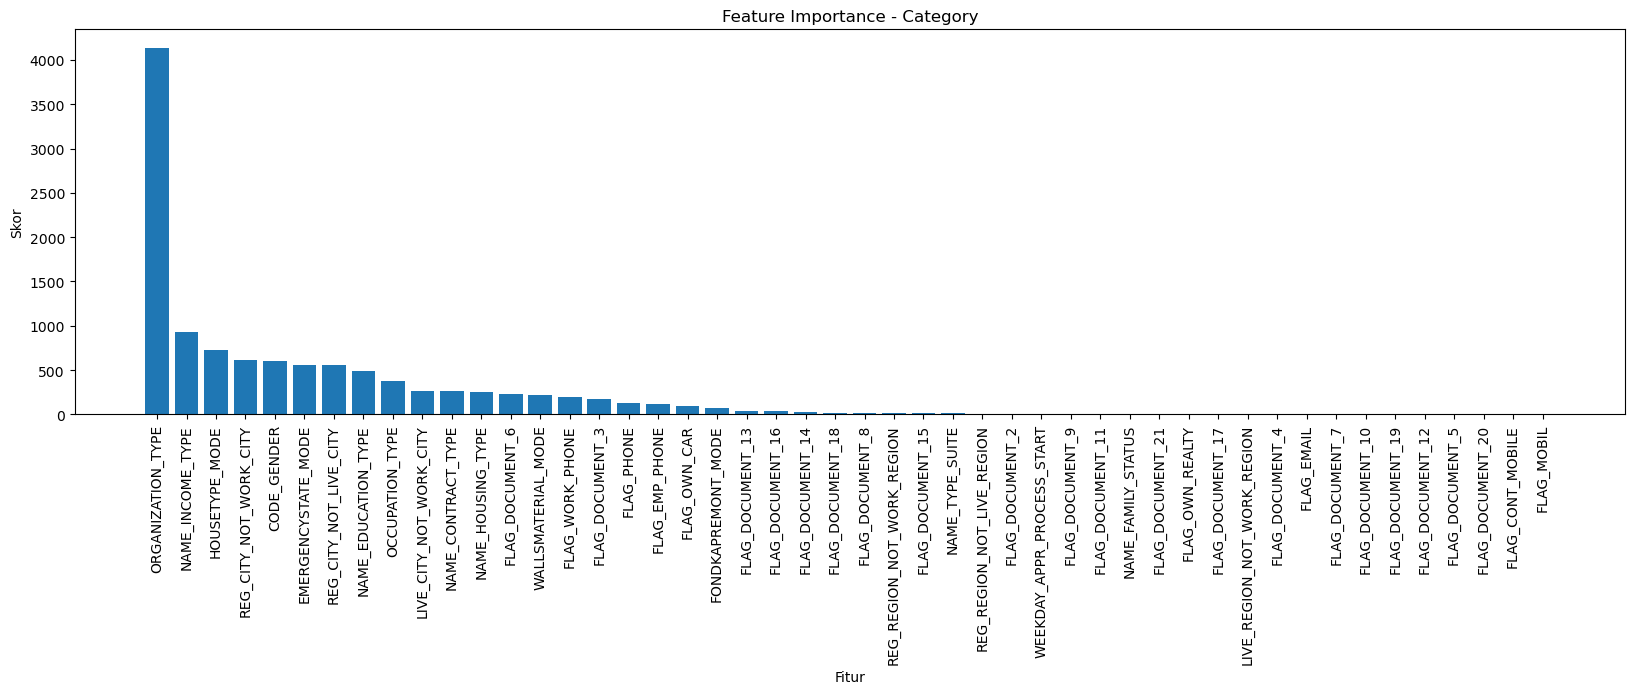

In [77]:
# Simpan skor dan nama fitur kategorikal dalam DataFrame
categorical_scores = pd.DataFrame({'Feature': selected_categorical_columns,
                                   'Score': selector_categorical.scores_})

# Sortir DataFrame berdasarkan skor secara menurun
categorical_scores = categorical_scores.sort_values(by='Score', ascending=False)

# Tampilkan tabel dengan menggunakan pandas
print("Feature Importance untuk Kolom Kategorikal:")
print(categorical_scores)

# Plot tabel menggunakan matplotlib
plt.figure(figsize=(20, 5))
plt.bar(categorical_scores['Feature'], categorical_scores['Score'])
plt.title('Feature Importance - Category')
plt.xlabel('Fitur')
plt.ylabel('Skor')
plt.xticks(rotation=90)
plt.show()

Feature using in modeling:
1. ORGANIZATION_TYPE
2. NAME_INCOME_TYPE
3. HOUSETYPE_MODE
4. CODE_GENDER
5. NAME_EDUCATION_TYPE
6. REG_CITY_NOT_WORK_CITY


In [78]:
encoded_categorical_data.head(2)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0,1,0,1,6,7,4,3,1,1,1,0,1,1,0,8,6,0,0,0,0,0,0,5,2,0,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,4,1,1,1,1,1,0,1,1,0,3,1,0,0,0,0,0,0,39,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Feature importance numeric

In [79]:
pd.set_option('display.max_row', None)
print(num.isnull().sum())
pd.reset_option('display.max_row')

SK_ID_CURR                           0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
CNT_FAM_MEMBERS                      2
REGION_RATING_CLIENT                 0
REGION_RATING_CLIENT_W_CITY          0
HOUR_APPR_PROCESS_START              0
EXT_SOURCE_1                    173378
EXT_SOURCE_2                       660
EXT_SOURCE_3                     60965
APARTMENTS_AVG                  156061
BASEMENTAREA_AVG                179943
YEARS_BEGINEXPLUATATION_AVG     150007
YEARS_BUILD_AVG                 204488
COMMONAREA_AVG                  214865
ELEVATORS_AVG                   163891
ENTRANCES_AVG            

In [80]:
num = num[numeric_cols].fillna(num[numeric_cols].mean())

# Normalisasi kolom numerik
scaler = MinMaxScaler()
num[numeric_cols] = scaler.fit_transform(num[numeric_cols])

In [81]:
pd.set_option('display.max_row', None)
print(num.isnull().sum())
pd.reset_option('display.max_row')

SK_ID_CURR                      0
CNT_CHILDREN                    0
AMT_INCOME_TOTAL                0
AMT_CREDIT                      0
AMT_ANNUITY                     0
AMT_GOODS_PRICE                 0
REGION_POPULATION_RELATIVE      0
DAYS_BIRTH                      0
DAYS_EMPLOYED                   0
DAYS_REGISTRATION               0
DAYS_ID_PUBLISH                 0
OWN_CAR_AGE                     0
CNT_FAM_MEMBERS                 0
REGION_RATING_CLIENT            0
REGION_RATING_CLIENT_W_CITY     0
HOUR_APPR_PROCESS_START         0
EXT_SOURCE_1                    0
EXT_SOURCE_2                    0
EXT_SOURCE_3                    0
APARTMENTS_AVG                  0
BASEMENTAREA_AVG                0
YEARS_BEGINEXPLUATATION_AVG     0
YEARS_BUILD_AVG                 0
COMMONAREA_AVG                  0
ELEVATORS_AVG                   0
ENTRANCES_AVG                   0
FLOORSMAX_AVG                   0
FLOORSMIN_AVG                   0
LANDAREA_AVG                    0
LIVINGAPARTMEN

In [82]:
num

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0.000000,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.888839,0.045086,0.852140,0.705433,0.132539,0.000000,0.5,0.5,0.434783,0.072215,0.307542,0.155054,0.02470,0.036900,0.972200,0.619200,0.014300,0.000000,0.069000,0.083300,0.125000,0.036900,0.020200,0.019000,0.000000,0.000000,0.025200,0.038300,0.972200,0.634100,0.014400,0.00000,0.069000,0.083300,0.125000,0.037700,0.022000,0.019800,0.000000,0.000000,0.02500,0.036900,0.972200,0.624300,0.014400,0.000000,0.069000,0.083300,0.125000,0.037500,0.020500,0.019300,0.000000,0.000000,0.014900,0.005747,0.058824,0.005814,0.083333,0.735788,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000
1,0.000003,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.477114,0.043648,0.951929,0.959566,0.132539,0.052632,0.0,0.0,0.478261,0.312933,0.727773,0.569889,0.09590,0.052900,0.985100,0.796000,0.060500,0.080000,0.034500,0.291700,0.333300,0.013000,0.077300,0.054900,0.003900,0.009800,0.092400,0.053800,0.985100,0.804000,0.049700,0.08060,0.034500,0.291700,0.333300,0.012800,0.079000,0.055400,0.000000,0.000000,0.09680,0.052900,0.985100,0.798700,0.060800,0.080000,0.034500,0.291700,0.333300,0.013200,0.078700,0.055800,0.003900,0.010000,0.071400,0.002874,0.000000,0.002907,0.000000,0.807083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000006,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.348534,0.046161,0.827335,0.648326,0.285714,0.000000,0.5,0.5,0.391304,0.514238,0.650190,0.814130,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.07449,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.11785,0.087955,0.977752,0.755746,0.044595,0.078078,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,0.000000,0.000000,0.000000,0.000000,0.810112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000011,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.350846,0.038817,0.601451,0.661387,0.132539,0.052632,0.5,0.5,0.739130,0.514238,0.760751,0.569889,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.07449,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.11785,0.087955,0.977752,0.755746,0.044595,0.078078,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,0.005747,0.000000,0.005814,0.000000,0.856244,0.001601,0.000778,0.004295,0.009904,0.001017,0.075999
4,0.000014,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,0.298591,0.038820,0.825268,0.5

In [83]:
application_train['TARGET'] = application_train['TARGET'].replace({'Y': 1, 'N': 0})

In [84]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,Y,Y,N,Y,Y,N,Laborers,1.0,2,2,WEDNESDAY,10,N,N,N,N,N,N,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,Y,Y,N,Y,Y,N,Core staff,2.0,1,1,MONDAY,11,N,N,N,N,N,N,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,Y,Y,Y,Y,Y,N,Laborers,1.0,2,2,MONDAY,9,N,N,N,N,N,N,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [85]:
selector_numeric = SelectKBest(score_func=mutual_info_regression, k=73)

# Fit dan transform untuk numerik
selected_numeric_features = selector_numeric.fit_transform(num[numeric_cols], application_train['TARGET'])
selected_numeric_indices = selector_numeric.get_support(indices=True)
selected_numeric_columns = num[numeric_cols].columns[selected_numeric_indices]

Feature Importance untuk Kolom Numerik:
                     Feature     Score
18              EXT_SOURCE_3  0.013742
17              EXT_SOURCE_2  0.012715
4                AMT_ANNUITY  0.011797
3                 AMT_CREDIT  0.006663
16              EXT_SOURCE_1  0.005910
..                       ...       ...
32         NONLIVINGAREA_AVG  0.000000
42             LANDAREA_MODE  0.000000
45  NONLIVINGAPARTMENTS_MODE  0.000000
55            FLOORSMIN_MEDI  0.000000
0                 SK_ID_CURR  0.000000

[73 rows x 2 columns]


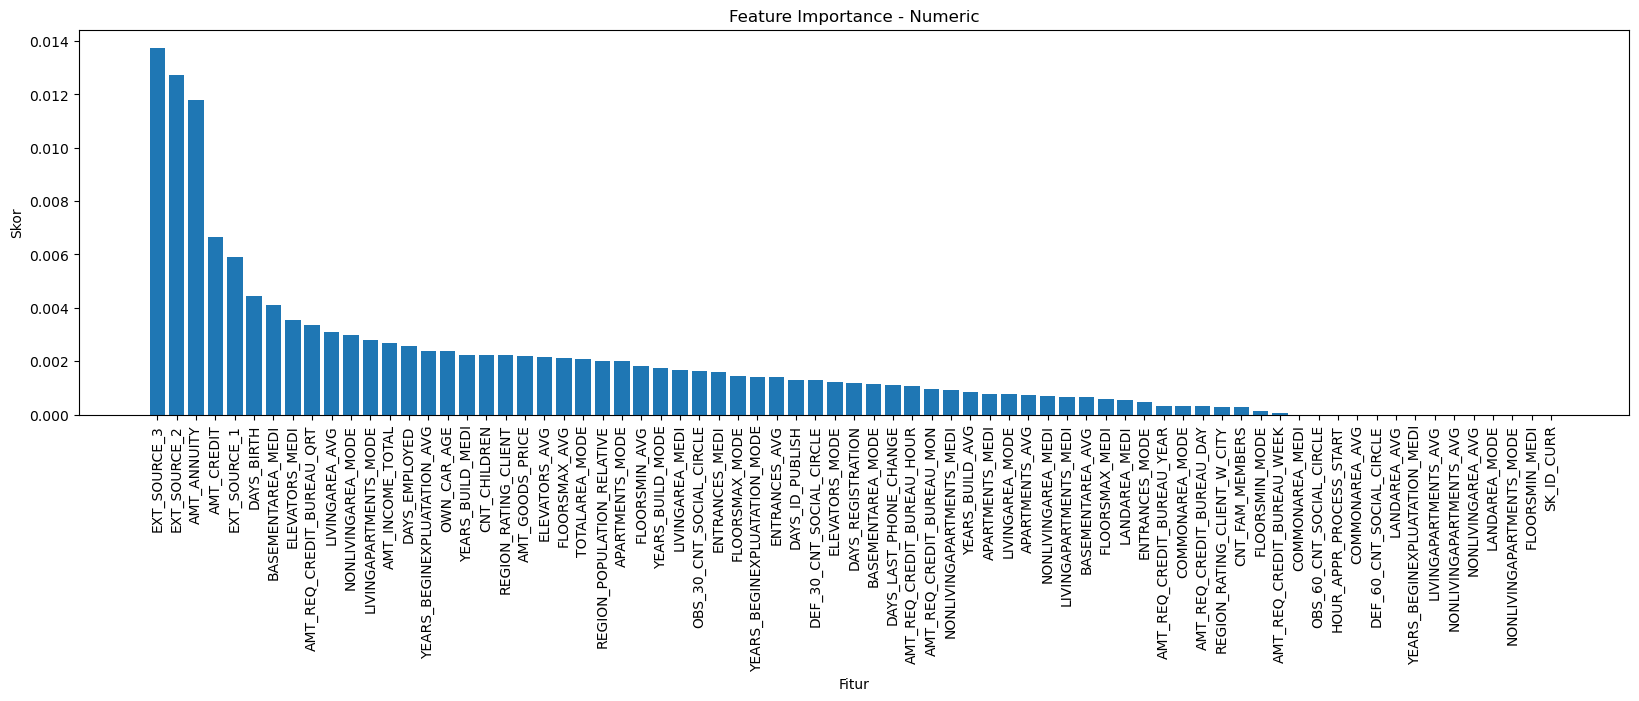

In [86]:
# Simpan skor dan nama fitur numerik dalam DataFrame
numeric_scores = pd.DataFrame({'Feature': selected_numeric_columns,
                               'Score': selector_numeric.scores_})

# Sortir DataFrame berdasarkan skor secara menurun
numeric_scores = numeric_scores.sort_values(by='Score', ascending=False)

# Tampilkan tabel dengan menggunakan pandas
print("Feature Importance untuk Kolom Numerik:")
print(numeric_scores)

# Plot tabel menggunakan matplotlib
plt.figure(figsize=(20, 5))
plt.bar(numeric_scores['Feature'], numeric_scores['Score'])
plt.title('Feature Importance - Numeric')
plt.xlabel('Fitur')
plt.ylabel('Skor')
plt.xticks(rotation=90)
plt.show()


Feature using in modeling
1. EXT_SOURCE_3
2. AMT_ANNUITY
3. EXT_SOURCE_2
4. AMT_CREDIT
5. EXT_SOURCE_2
6. DAYS_BIRTH
7. AMT_GOODS_PRICE

In [87]:
pd.set_option('display.max_row', None)
print(application_train.isnull().sum())
pd.reset_option('display.max_row')

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

In [88]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,Y,Y,N,Y,Y,N,Laborers,1.0,2,2,WEDNESDAY,10,N,N,N,N,N,N,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,Y,Y,N,Y,Y,N,Core staff,2.0,1,1,MONDAY,11,N,N,N,N,N,N,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,Y,Y,Y,Y,Y,N,Laborers,1.0,2,2,MONDAY,9,N,N,N,N,N,N,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [89]:
pd.set_option('display.max_row', None)
print(numeric_scores)
pd.reset_option('display.max_row')

                         Feature     Score
18                  EXT_SOURCE_3  0.013742
17                  EXT_SOURCE_2  0.012715
4                    AMT_ANNUITY  0.011797
3                     AMT_CREDIT  0.006663
16                  EXT_SOURCE_1  0.005910
7                     DAYS_BIRTH  0.004429
48             BASEMENTAREA_MEDI  0.004102
52                ELEVATORS_MEDI  0.003560
71     AMT_REQ_CREDIT_BUREAU_QRT  0.003348
30                LIVINGAREA_AVG  0.003088
46            NONLIVINGAREA_MODE  0.003000
43         LIVINGAPARTMENTS_MODE  0.002810
2               AMT_INCOME_TOTAL  0.002688
8                  DAYS_EMPLOYED  0.002572
21   YEARS_BEGINEXPLUATATION_AVG  0.002401
11                   OWN_CAR_AGE  0.002385
50              YEARS_BUILD_MEDI  0.002241
1                   CNT_CHILDREN  0.002219
13          REGION_RATING_CLIENT  0.002218
5                AMT_GOODS_PRICE  0.002210
24                 ELEVATORS_AVG  0.002167
26                 FLOORSMAX_AVG  0.002136
61         

In [90]:
data = pd.DataFrame()
feature_importance = ['SK_ID_CURR','TARGET',
                                    'ORGANIZATION_TYPE','NAME_INCOME_TYPE','HOUSETYPE_MODE','CODE_GENDER','NAME_EDUCATION_TYPE','REG_CITY_NOT_WORK_CITY',
                                    'DAYS_BIRTH','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','AMT_ANNUITY','AMT_CREDIT','AMT_GOODS_PRICE']
data = application_train[feature_importance]

In [91]:
cat = ['TARGET','ORGANIZATION_TYPE','NAME_INCOME_TYPE','HOUSETYPE_MODE','CODE_GENDER','NAME_EDUCATION_TYPE','REG_CITY_NOT_WORK_CITY']
cat = application_train[cat]
num = ['TARGET','DAYS_BIRTH','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','AMT_ANNUITY','AMT_CREDIT','AMT_GOODS_PRICE']
num = application_train[num]

In [92]:
data.isnull().sum()

SK_ID_CURR                     0
TARGET                         0
ORGANIZATION_TYPE              0
NAME_INCOME_TYPE               0
HOUSETYPE_MODE            154297
CODE_GENDER                    0
NAME_EDUCATION_TYPE            0
REG_CITY_NOT_WORK_CITY         0
DAYS_BIRTH                     0
EXT_SOURCE_1              173378
EXT_SOURCE_2                 660
EXT_SOURCE_3               60965
AMT_ANNUITY                   12
AMT_CREDIT                     0
AMT_GOODS_PRICE              278
dtype: int64

In [93]:
data.nunique()

SK_ID_CURR                307511
TARGET                         2
ORGANIZATION_TYPE             58
NAME_INCOME_TYPE               8
HOUSETYPE_MODE                 3
CODE_GENDER                    3
NAME_EDUCATION_TYPE            5
REG_CITY_NOT_WORK_CITY         2
DAYS_BIRTH                 17460
EXT_SOURCE_1              114584
EXT_SOURCE_2              119831
EXT_SOURCE_3                 814
AMT_ANNUITY                13672
AMT_CREDIT                  5603
AMT_GOODS_PRICE             1002
dtype: int64

# Univariate Categorical

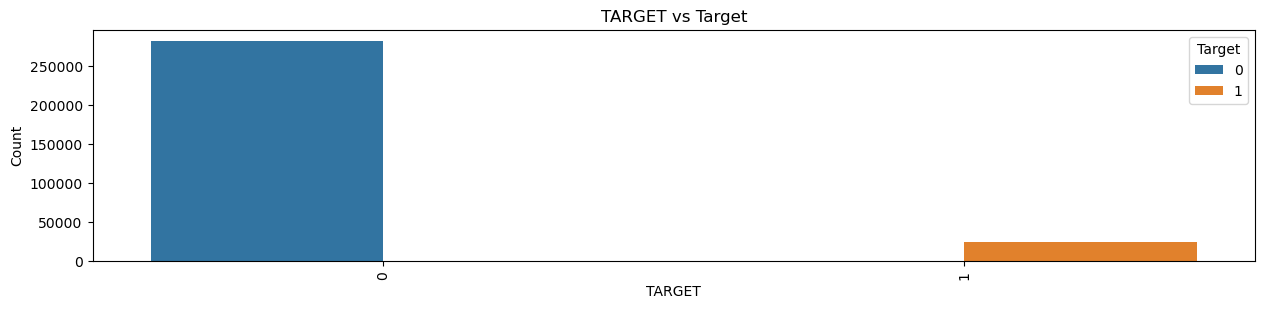

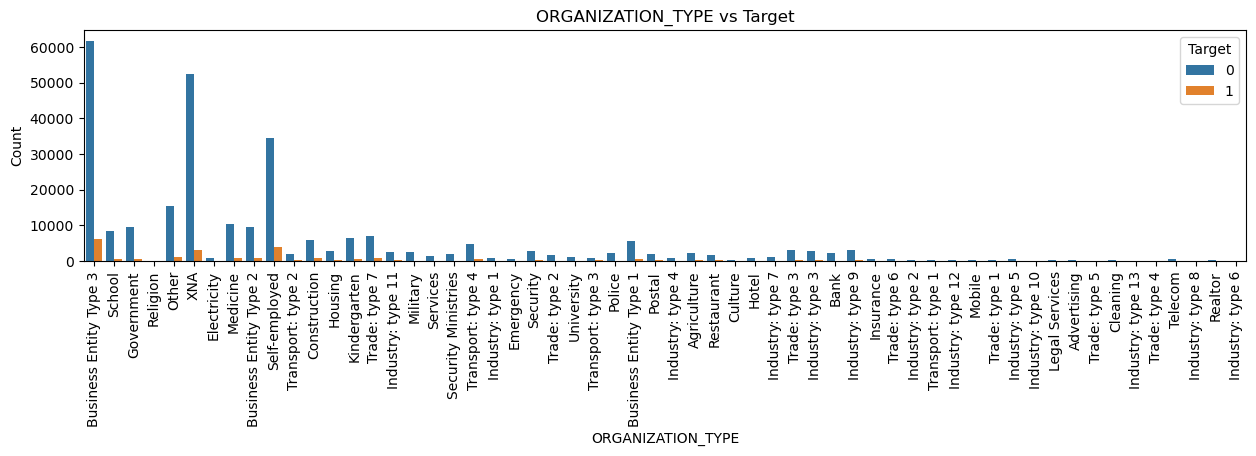

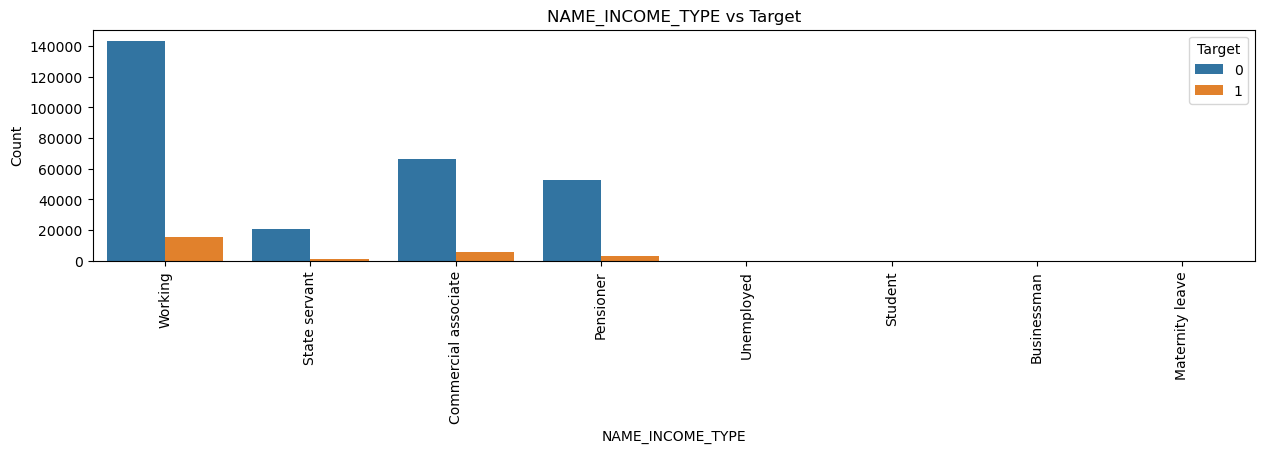

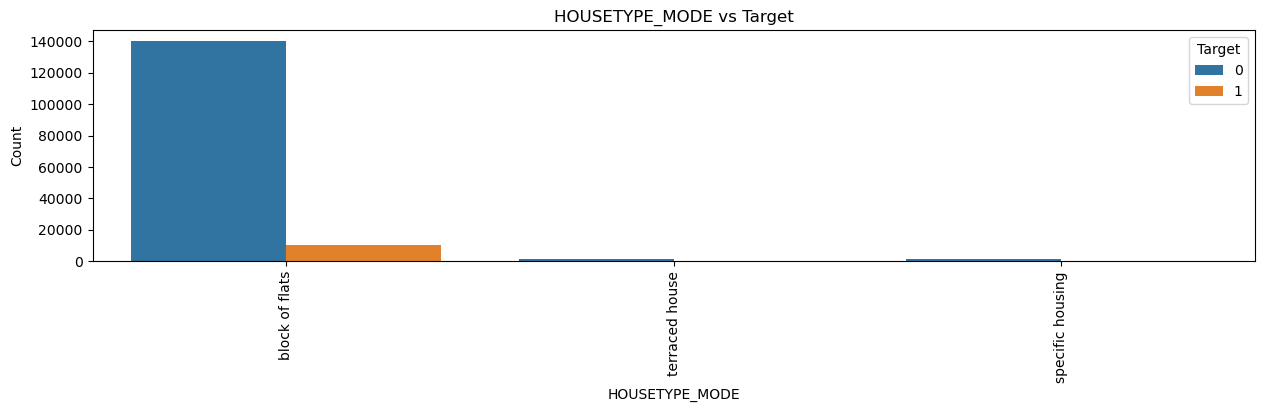

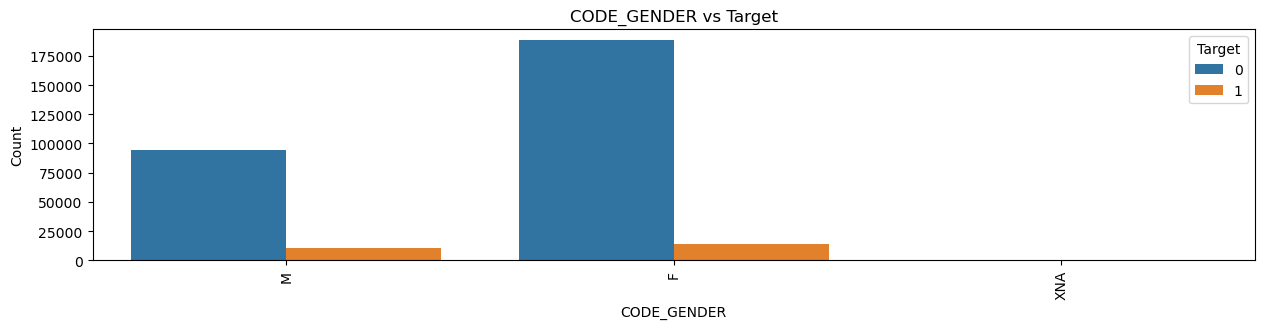

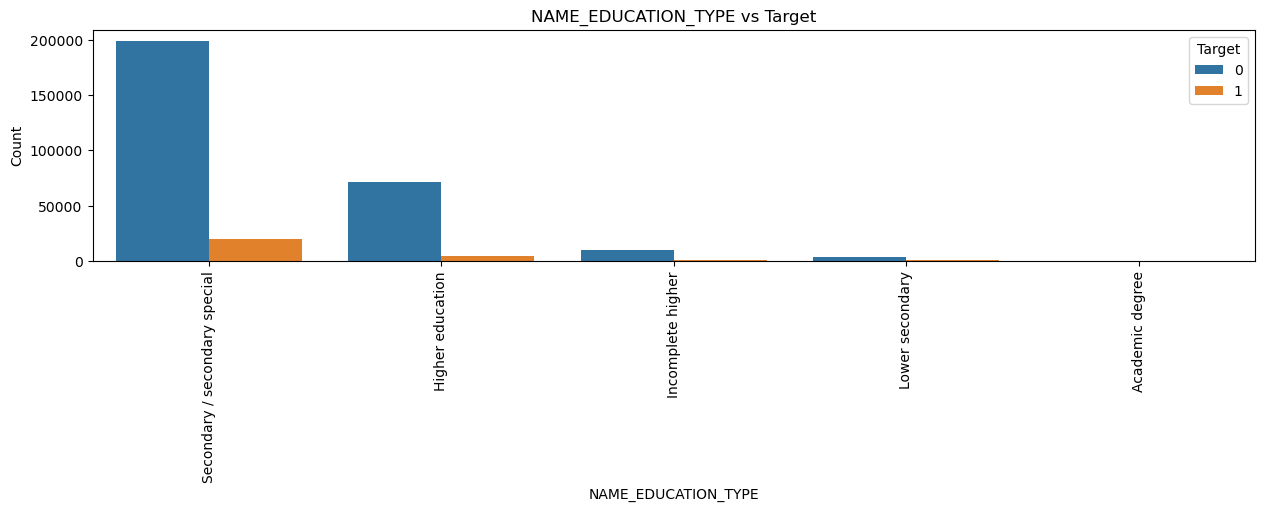

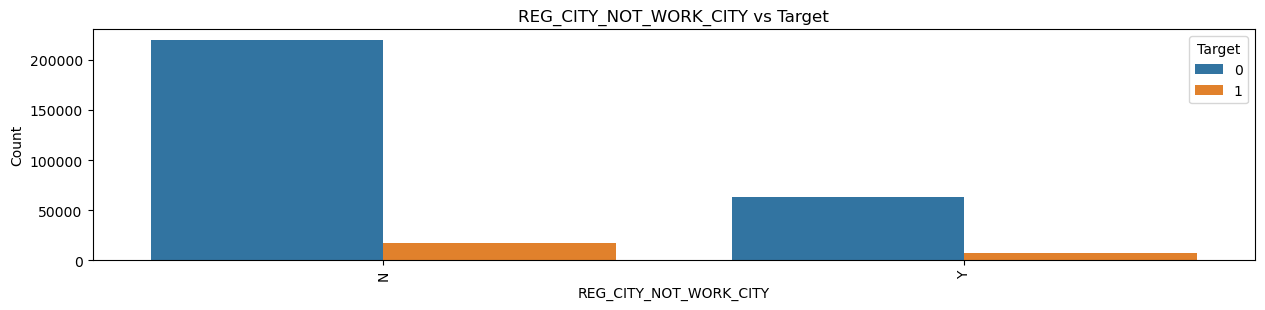

In [94]:
for col in cat:
    plt.figure(figsize=(15, 3))
    sns.countplot(x=col, hue='TARGET', data=cat)
    plt.title(f'{col} vs Target')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Target', loc='upper right')
    plt.xticks(rotation=90)
    plt.show()

# Univariate  Numerical

In [95]:
num.describe()

,TARGET,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE
count,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,307499.000000,3.075110e+05,3.072330e+05
mean,0.080729,-16036.995067,0.502130,5.143927e-01,0.510853,27108.573909,5.990260e+05,5.383962e+05
std,0.272419,4363.988632,0.211062,1.910602e-01,0.194844,14493.737315,4.024908e+05,3.694465e+05
min,0.000000,-25229.000000,0.014568,8.173617e-08,0.000527,1615.500000,4.500000e+04,4.050000e+04
25%,0.000000,-19682.000000,0.334007,3.924574e-01,0.370650,16524.000000,2.700000e+05,2.385000e+05
50%,0.000000,-15750.000000,0.505998,5.659614e-01,0.535276,24903.000000,5.135310e+05,4.500000e+05
75%,0.000000,-12413.000000,0.675053,6.636171e-01,0.669057,34596.000000,8.086500e+05,6.795000e+05
max,1.000000,-7489.000000,0.962693,8.549997e-01,0.896010,258025.500000,4.050000e+06,4.050000e+06


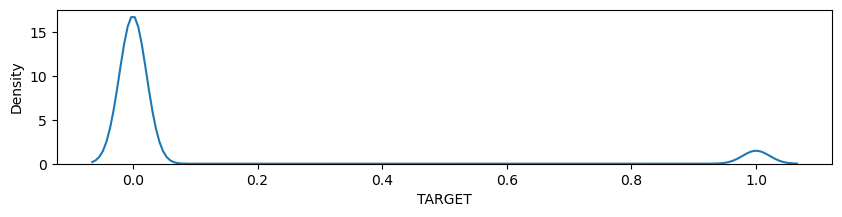

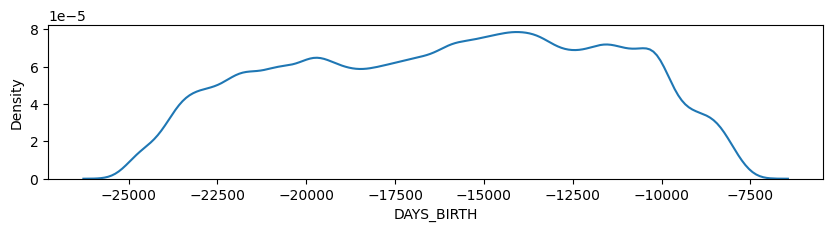

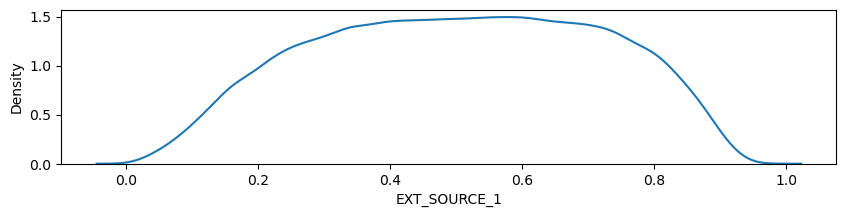

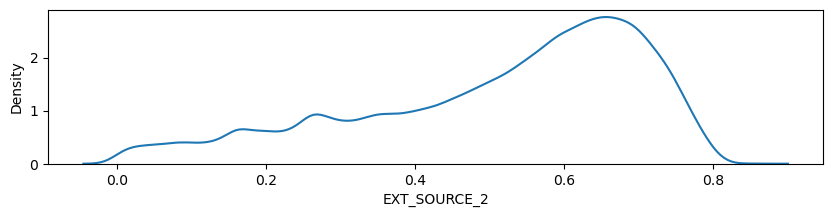

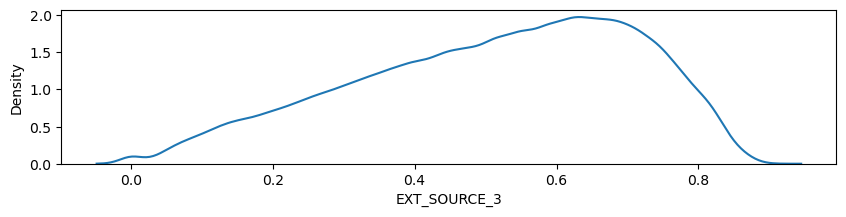

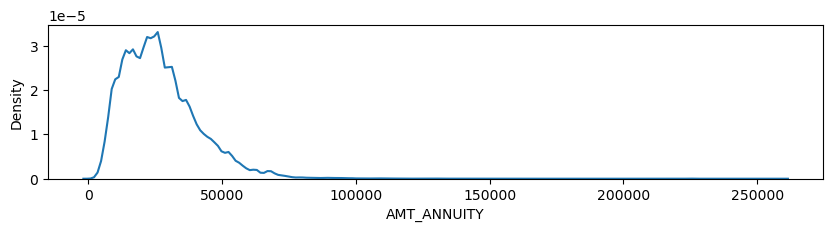

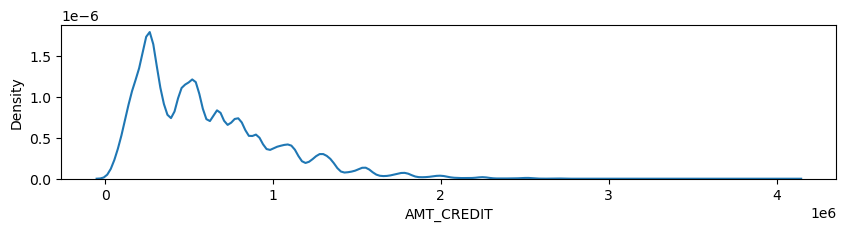

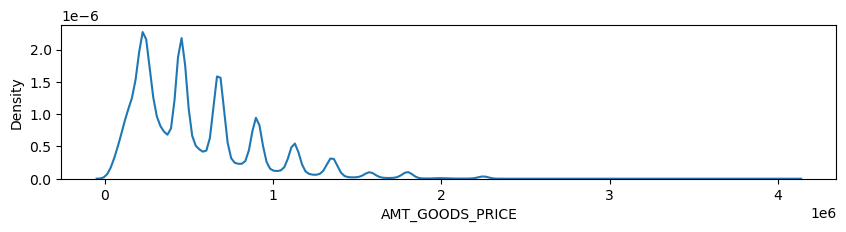

In [96]:
for col in num:
    plt.figure(figsize=(10, 2))
    sns.kdeplot(data=num, x=col)
    plt.show()

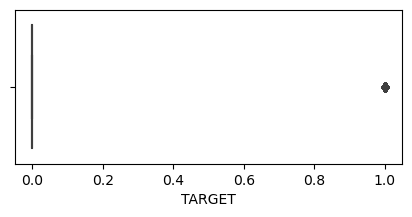

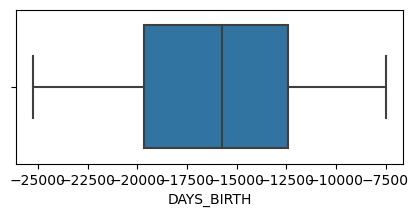

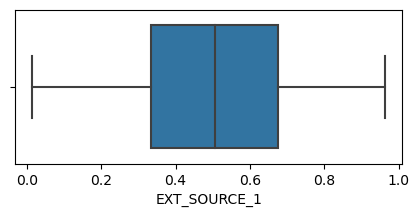

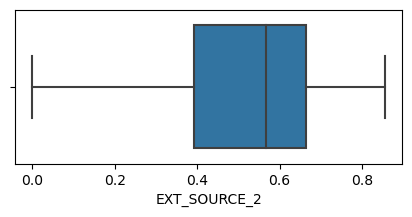

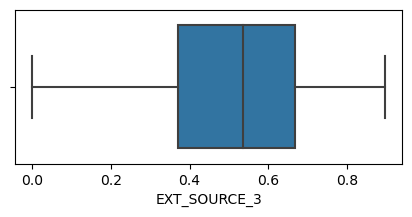

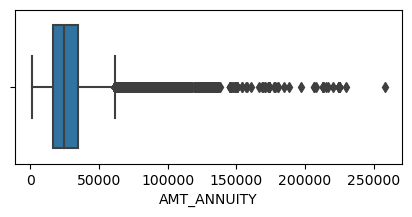

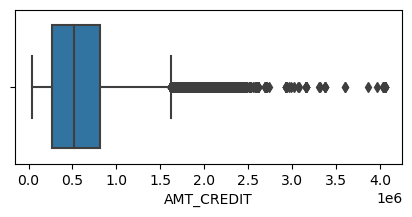

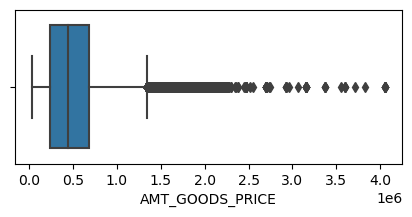

In [97]:
for col in num:
    plt.figure(figsize=(5, 2))
    sns.boxplot(data=num, x=col)
    plt.show()

# Bivariate

# numerical

<Axes: >

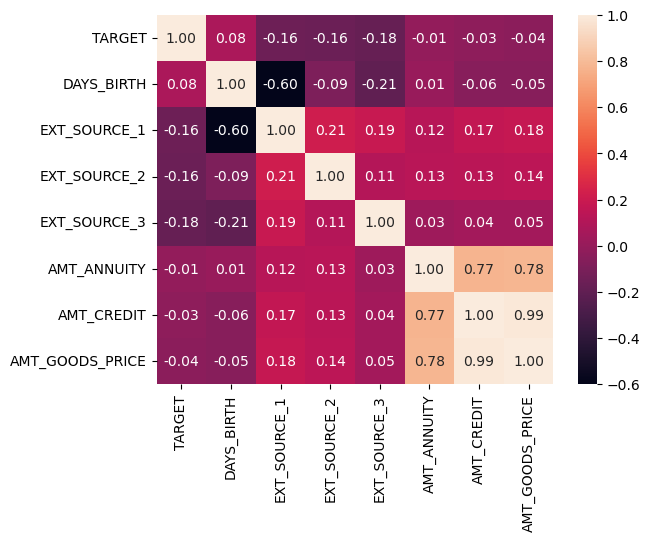

In [98]:
sns.heatmap(num.corr(),annot=True, fmt='.2f')

# Categorical

In [99]:
'''results_df = pd.DataFrame(columns=['Variable 1', 'Variable 2', 'Chi-square', 'p-value', 'Degrees of Freedom'])

# Loop melalui setiap pasangan kolom kategorikal
for col1 in cat:
    for col2 in cat:
        if col1 != col2:
            # Buat contingency table
            contingency_table = pd.crosstab(data[col1], data[col2])
            
            # Lakukan chi-square test
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            
            # Tambahkan hasil ke DataFrame
            results_df = results_df.append({'Variable 1': col1,
                                            'Variable 2': col2,
                                            'Chi-square': chi2,
                                            'p-value': p_value,
                                            'Degrees of Freedom': dof},
                                           ignore_index=True)'''

"results_df = pd.DataFrame(columns=['Variable 1', 'Variable 2', 'Chi-square', 'p-value', 'Degrees of Freedom'])\n\n# Loop melalui setiap pasangan kolom kategorikal\nfor col1 in cat:\n    for col2 in cat:\n        if col1 != col2:\n            # Buat contingency table\n            contingency_table = pd.crosstab(data[col1], data[col2])\n            \n            # Lakukan chi-square test\n            chi2, p_value, dof, expected = chi2_contingency(contingency_table)\n            \n            # Tambahkan hasil ke DataFrame\n            results_df = results_df.append({'Variable 1': col1,\n                                            'Variable 2': col2,\n                                            'Chi-square': chi2,\n                                            'p-value': p_value,\n                                            'Degrees of Freedom': dof},\n                                           ignore_index=True)"

In [100]:
cat = cat.drop('TARGET', axis =1)
num = num.drop('TARGET', axis =1)

# Numerical vs Categorical

In [101]:
'''# Variabel numerik
numeric_vars = ['DAYS_BIRTH','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','AMT_ANNUITY','AMT_CREDIT','AMT_GOODS_PRICE']  # Ganti dengan nama kolom variabel numerik Anda

# Variabel kategorikal
categorical_vars = ['ORGANIZATION_TYPE','NAME_INCOME_TYPE','HOUSETYPE_MODE','CODE_GENDER','NAME_EDUCATION_TYPE','REG_CITY_NOT_WORK_CITY']  # Ganti dengan nama kolom variabel kategorikal Anda

# T-test
for numeric_var in numeric_vars:
    for categorical_var in categorical_vars:
        for category in data[categorical_var].unique():
            subset = data[data[categorical_var] == category]
            t_score, p_value = stats.ttest_ind(subset[numeric_var], data[numeric_var])
            print(f"T-test for {numeric_var} and {categorical_var}({category}):")
            print("T-score:", t_score)
            print("p-value:", p_value)'''

'# Variabel numerik\nnumeric_vars = [\'DAYS_BIRTH\',\'EXT_SOURCE_1\',\'EXT_SOURCE_2\',\'EXT_SOURCE_3\',\'AMT_ANNUITY\',\'AMT_CREDIT\',\'AMT_GOODS_PRICE\']  # Ganti dengan nama kolom variabel numerik Anda\n\n# Variabel kategorikal\ncategorical_vars = [\'ORGANIZATION_TYPE\',\'NAME_INCOME_TYPE\',\'HOUSETYPE_MODE\',\'CODE_GENDER\',\'NAME_EDUCATION_TYPE\',\'REG_CITY_NOT_WORK_CITY\']  # Ganti dengan nama kolom variabel kategorikal Anda\n\n# T-test\nfor numeric_var in numeric_vars:\n    for categorical_var in categorical_vars:\n        for category in data[categorical_var].unique():\n            subset = data[data[categorical_var] == category]\n            t_score, p_value = stats.ttest_ind(subset[numeric_var], data[numeric_var])\n            print(f"T-test for {numeric_var} and {categorical_var}({category}):")\n            print("T-score:", t_score)\n            print("p-value:", p_value)'

# Combine Dataset

In [102]:
credit_card_balance_agg
installment_agg_last5
POS_CASH_balance_agg
df_last_5
bureau_agg
data

,SK_ID_CURR,TARGET,ORGANIZATION_TYPE,NAME_INCOME_TYPE,HOUSETYPE_MODE,CODE_GENDER,NAME_EDUCATION_TYPE,REG_CITY_NOT_WORK_CITY,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE
0,100002,1,Business Entity Type 3,Working,block of flats,M,Secondary / secondary special,N,-9461,0.083037,0.262949,0.139376,24700.5,406597.5,351000.0
1,100003,0,School,State servant,block of flats,F,Higher education,N,-16765,0.311267,0.622246,NaN,35698.5,1293502.5,1129500.0
2,100004,0,Government,Working,NaN,M,Secondary / secondary special,N,-19046,NaN,0.555912,0.729567,6750.0,135000.0,135000.0
3,100006,0,Business Entity Type 3,Working,NaN,F,Secondary / secondary special,N,-19005,NaN,0.650442,NaN,29686.5,312682.5,297000.0
4,100007,0,Religion,Working,NaN,M,Secondary / secondary special,Y,-19932,NaN,0.322738,NaN,21865.5,513000.0,513000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Services,Working,block of flats,M,Secondary / secondary special,N,-9327,0.145570,0.681632,NaN,27558.0,254700.0,225000.0
307507,456252,0,XNA,Pensioner,block of flats,F,Secondary / secondary special,N,-20775,NaN,0.115992,NaN,12001.5,269550.0,225000.0
307508,456253,0,School,Working,block of flats,F,Higher education,Y,-14966,0.744026,0.535722,0.218859,29979.0,677664.0,585000.0
307509,456254,1,Business Entity Type 1,Commercial associate,block of flats,F,Secondary / secondary special,Y,-11961,NaN,0.514163,0.661024,20205.0,370107.0,319500.0


In [103]:
import pandas as pd
from functools import reduce

# Daftar semua dataset
datasets = [data, credit_card_balance_agg, installment_agg_last5, POS_CASH_balance_agg, df_last_5, bureau_agg]

# Lakukan inner join berdasarkan SK_ID_CURR
merged_df = reduce(lambda left, right: pd.merge(left, right, on='SK_ID_CURR', how='inner'), datasets)

# merged_df akan berisi hasil inner join dari semua dataset berdasarkan SK_ID_CURR
merged_df

,SK_ID_CURR,TARGET,ORGANIZATION_TYPE,NAME_INCOME_TYPE,HOUSETYPE_MODE,CODE_GENDER,NAME_EDUCATION_TYPE,REG_CITY_NOT_WORK_CITY,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_ANNUITY_x,AMT_CREDIT_x,AMT_GOODS_PRICE,MONTHS_BALANCE_x,CNT_INSTALMENT_MATURE_CUM_x,SK_ID_PREV,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,max_current,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,SK_DPD_x,SK_DPD_DEF_x,unpaid_invoice_amount,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_DPD_y,SK_DPD_DEF_y,DIF_SK_DPD_SK_DPD_DEF,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,NAME_CONTRACT_STATUS,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,DAYS_CREDIT_UPDATE
0,100011,0,XNA,Pensioner,NaN,F,Secondary / secondary special,N,-20099,0.587334,0.205747,0.751724,33826.5,1019610.0,913500.0,75,33.0,1843384,0.000,90000,90000.000,0.00,0.0,0.00,0,0,0,0.00,0.4,2237.0,2253.0,64472.940,58858.605,15425,26,15399,18303.19500,810931.5,1047361.5,Approved,435228.300,0.000,-965
1,100023,0,Kindergarten,State servant,NaN,F,Higher education,N,-11348,NaN,0.586617,0.477649,17563.5,544491.0,454500.0,11,0.0,1499902,0.000,225000,225000.000,0.00,0.0,0.00,0,0,0,0.00,1.2,2363.0,2363.0,264841.785,264841.785,0,0,0,8895.89250,394987.5,454068.0,Approved,1645692.345,137038.500,-5
2,100036,0,Services,Working,block of flats,F,Secondary / secondary special,N,-11144,0.274422,0.627300,NaN,25033.5,512064.0,360000.0,13,0.0,2621538,0.000,90000,90000.000,0.00,0.0,0.00,0,0,0,0.00,1.0,365.0,381.0,32757.075,32757.075,0,0,0,10204.94250,668106.0,697810.5,Refused,94959.000,8339.355,-519
3,100043,0,Other,Commercial associate,NaN,F,Secondary / secondary special,N,-17199,0.842763,0.681699,0.754406,23157.0,641173.5,553500.0,33,20.0,1557583,0.000,22500,22500.000,0.00,0.0,0.00,0,0,0,0.00,0.4,1039.0,1052.0,59579.550,42479.550,0,0,0,45592.42500,4760775.0,4995580.5,Refused,333720.000,0.000,-127
4,100047,1,Business Entity Type 3,Commercial associate,block of flats,M,Secondary / secondary special,N,-17482,NaN,0.306841,0.320163,35028.0,1193580.0,855000.0,39,0.0,1472630,0.000,45000,45000.000,0.00,0.0,0.00,0,0,0,0.00,1.0,2481.0,2489.0,42526.890,42526.890,0,0,0,17876.35800,1298205.0,1875411.0,Approved,9527634.000,3220456.500,-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72788,456241,0,Trade: type 7,Working,NaN,F,Secondary / secondary special,Y,-16679,0.251096,0.651306,0.524496,12028.5,270126.0,193500.0,34,0.0,1509615,0.000,45000,45000.000,0.00,0.0,0.00,0,0,0,0.00,1.0,1281.0,1286.0,62369.415,56774.475,0,0,0,16587.09900,1504345.5,1935045.0,Approved,1215000.000,0.000,-224
72789,456242,0,Construction,Commercial associate,block of flats,M,Secondary / secondary special,N,-19102,NaN,0.746259,0.406617,52168.5,1312110.0,1125000.0,8,7.0,2640681,208711.890,225000,433711.890,11005.56,15804.0,208711.89,0,0,0,192907.89,0.8,703.0,719.0,88137.270,88137.270,0,0,0,11054.52000,397764.0,426658.5,Approved,198000.000,186097.500,-5
72790,456244,0,Business Entity Type 3,Working,block of flats,F,Higher education,N,-20390,0.896042,0.789389,0.337673,35982.0,1303812.0,1138500.0,41,17.0,2181926,0.000,0,0.000,0.00,0.0,0.00,0,0,0,0.00,0.4,1164.0,1183.0,135844.515,135844.515,7,7,0,30528.45000,2461500.0,2641986.0,Approved,7509015.495,611645.355,-12
72791,456246,0,School,Working,NaN,F,Secondary / secondary special,Y,-16063,NaN,0.313334,0.735221,10620.0,225000.0,225000.0,9,7.0,1079732,62.685,135000,135062.685,130.50,0.0,62.19,1,0,0,62.19,0.0,200.0,216.0,14863.455,14863.455,0,0,0,6748.83000,36031.5,168093.0,Approved,382500.000,0.000,-46


In [104]:
merged_df.isnull().sum()

SK_ID_CURR                         0
TARGET                             0
ORGANIZATION_TYPE                  0
NAME_INCOME_TYPE                   0
HOUSETYPE_MODE                 35423
CODE_GENDER                        0
NAME_EDUCATION_TYPE                0
REG_CITY_NOT_WORK_CITY             0
DAYS_BIRTH                         0
EXT_SOURCE_1                   38970
EXT_SOURCE_2                      20
EXT_SOURCE_3                    4601
AMT_ANNUITY_x                      7
AMT_CREDIT_x                       0
AMT_GOODS_PRICE                    6
MONTHS_BALANCE_x                   0
CNT_INSTALMENT_MATURE_CUM_x        0
SK_ID_PREV                         0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
max_current                        0
AMT_INST_MIN_REGULARITY            0
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_CURRENT               0
SK_DPD_x                           0
SK_DPD_DEF_x                       0
u

drop:
1. AMT_ANNUITY_y
2. AMT_CREDIT_y
3. SK_DPD_y
4. SK_DPD_DEF_y
5. SK_ID_PREV

In [105]:
drop = ['AMT_ANNUITY_y','AMT_CREDIT_y','SK_DPD_y','SK_DPD_DEF_y','SK_ID_PREV']
merged_df = merged_df.drop(drop, axis =1)

In [106]:
def create_categorical_dataset(df):
    non_numeric_columns = df.select_dtypes(exclude=['number']).columns.tolist()
    categorical_df = df[non_numeric_columns].copy()

    for column in non_numeric_columns:
        categorical_df[column] = categorical_df[column].astype('category')

    return categorical_df

def create_numeric_dataset(df):
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    numeric_df = df[numeric_columns].copy()

    return numeric_df

In [107]:
cat = create_categorical_dataset(merged_df)
cat

num = create_numeric_dataset(merged_df)
num

,SK_ID_CURR,TARGET,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_ANNUITY_x,AMT_CREDIT_x,AMT_GOODS_PRICE,MONTHS_BALANCE_x,CNT_INSTALMENT_MATURE_CUM_x,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,max_current,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_CURRENT,SK_DPD_x,SK_DPD_DEF_x,unpaid_invoice_amount,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DIF_SK_DPD_SK_DPD_DEF,AMT_APPLICATION,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,DAYS_CREDIT_UPDATE
0,100011,0,-20099,0.587334,0.205747,0.751724,33826.5,1019610.0,913500.0,75,33.0,0.000,90000,90000.000,0.00,0.0,0.00,0,0,0,0.00,0.4,2237.0,2253.0,64472.940,58858.605,15399,810931.5,435228.300,0.000,-965
1,100023,0,-11348,NaN,0.586617,0.477649,17563.5,544491.0,454500.0,11,0.0,0.000,225000,225000.000,0.00,0.0,0.00,0,0,0,0.00,1.2,2363.0,2363.0,264841.785,264841.785,0,394987.5,1645692.345,137038.500,-5
2,100036,0,-11144,0.274422,0.627300,NaN,25033.5,512064.0,360000.0,13,0.0,0.000,90000,90000.000,0.00,0.0,0.00,0,0,0,0.00,1.0,365.0,381.0,32757.075,32757.075,0,668106.0,94959.000,8339.355,-519
3,100043,0,-17199,0.842763,0.681699,0.754406,23157.0,641173.5,553500.0,33,20.0,0.000,22500,22500.000,0.00,0.0,0.00,0,0,0,0.00,0.4,1039.0,1052.0,59579.550,42479.550,0,4760775.0,333720.000,0.000,-127
4,100047,1,-17482,NaN,0.306841,0.320163,35028.0,1193580.0,855000.0,39,0.0,0.000,45000,45000.000,0.00,0.0,0.00,0,0,0,0.00,1.0,2481.0,2489.0,42526.890,42526.890,0,1298205.0,9527634.000,3220456.500,-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72788,456241,0,-16679,0.251096,0.651306,0.524496,12028.5,270126.0,193500.0,34,0.0,0.000,45000,45000.000,0.00,0.0,0.00,0,0,0,0.00,1.0,1281.0,1286.0,62369.415,56774.475,0,1504345.5,1215000.000,0.000,-224
72789,456242,0,-19102,NaN,0.746259,0.406617,52168.5,1312110.0,1125000.0,8,7.0,208711.890,225000,433711.890,11005.56,15804.0,208711.89,0,0,0,192907.89,0.8,703.0,719.0,88137.270,88137.270,0,397764.0,198000.000,186097.500,-5
72790,456244,0,-20390,0.896042,0.789389,0.337673,35982.0,1303812.0,1138500.0,41,17.0,0.000,0,0.000,0.00,0.0,0.00,0,0,0,0.00,0.4,1164.0,1183.0,135844.515,135844.515,0,2461500.0,7509015.495,611645.355,-12
72791,456246,0,-16063,NaN,0.313334,0.735221,10620.0,225000.0,225000.0,9,7.0,62.685,135000,135062.685,130.50,0.0,62.19,1,0,0,62.19,0.0,200.0,216.0,14863.455,14863.455,0,36031.5,382500.000,0.000,-46


In [108]:
encoder = LabelEncoder()
encoded_categorical_data = cat.apply(encoder.fit_transform)

In [109]:
selector_categorical = SelectKBest(score_func=chi2, k=7)

# Fit dan transform untuk kategorikal
selected_categorical_features = selector_categorical.fit_transform(encoded_categorical_data, merged_df['TARGET'])
selected_categorical_indices = selector_categorical.get_support(indices=True)
selected_categorical_columns = encoded_categorical_data.columns[selected_categorical_indices]

Feature Importance untuk Kolom Kategorikal:
                  Feature       Score
0       ORGANIZATION_TYPE  504.964004
6    NAME_CONTRACT_STATUS  241.803046
1        NAME_INCOME_TYPE  157.697125
2          HOUSETYPE_MODE  139.048019
5  REG_CITY_NOT_WORK_CITY  119.839225
3             CODE_GENDER  108.629843
4     NAME_EDUCATION_TYPE   90.977070


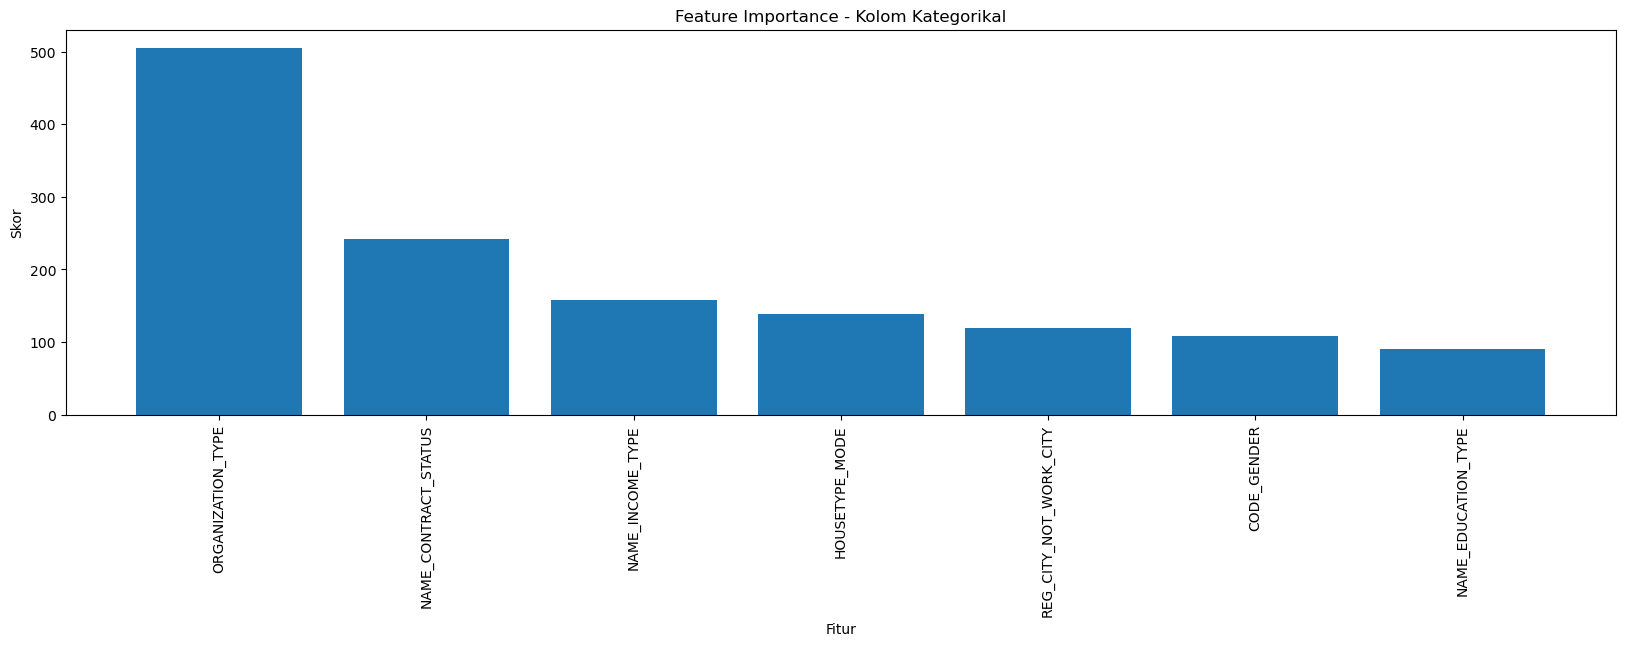

In [110]:
# Simpan skor dan nama fitur kategorikal dalam DataFrame
categorical_scores = pd.DataFrame({'Feature': selected_categorical_columns,
                                   'Score': selector_categorical.scores_})

# Sortir DataFrame berdasarkan skor secara menurun
categorical_scores = categorical_scores.sort_values(by='Score', ascending=False)

# Tampilkan tabel dengan menggunakan pandas
print("Feature Importance untuk Kolom Kategorikal:")
print(categorical_scores)

# Plot tabel menggunakan matplotlib
plt.figure(figsize=(20, 5))
plt.bar(categorical_scores['Feature'], categorical_scores['Score'])
plt.title('Feature Importance - Kolom Kategorikal')
plt.xlabel('Fitur')
plt.ylabel('Skor')
plt.xticks(rotation=90)
plt.show()

In [111]:
drop = ['SK_ID_CURR', 'TARGET']
num = num.drop(drop, axis =1)
num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72793 entries, 0 to 72792
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DAYS_BIRTH                   72793 non-null  int64  
 1   EXT_SOURCE_1                 33823 non-null  float64
 2   EXT_SOURCE_2                 72773 non-null  float64
 3   EXT_SOURCE_3                 68192 non-null  float64
 4   AMT_ANNUITY_x                72786 non-null  float64
 5   AMT_CREDIT_x                 72793 non-null  float64
 6   AMT_GOODS_PRICE              72787 non-null  float64
 7   MONTHS_BALANCE_x             72793 non-null  int64  
 8   CNT_INSTALMENT_MATURE_CUM_x  72793 non-null  float64
 9   AMT_BALANCE                  72793 non-null  float64
 10  AMT_CREDIT_LIMIT_ACTUAL      72793 non-null  int64  
 11  max_current                  72793 non-null  float64
 12  AMT_INST_MIN_REGULARITY      72793 non-null  float64
 13  AMT_PAYMENT_TOTA

In [112]:
for col in num:
    mean_value = num[col].mean()
    num[col].fillna(mean_value, inplace=True)

Feature Importance untuk Kolom Numerik:
                        Feature     Score
3                  EXT_SOURCE_3  0.018465
2                  EXT_SOURCE_2  0.011838
18        unpaid_invoice_amount  0.010204
4                 AMT_ANNUITY_x  0.010115
9                   AMT_BALANCE  0.008882
14         AMT_TOTAL_RECEIVABLE  0.008801
11                  max_current  0.007887
12      AMT_INST_MIN_REGULARITY  0.007259
20              DAYS_INSTALMENT  0.006431
17                 SK_DPD_DEF_x  0.004171
13    AMT_PAYMENT_TOTAL_CURRENT  0.004073
5                  AMT_CREDIT_x  0.004053
25              AMT_APPLICATION  0.003953
1                  EXT_SOURCE_1  0.003783
10      AMT_CREDIT_LIMIT_ACTUAL  0.003684
7              MONTHS_BALANCE_x  0.003284
19       NUM_INSTALMENT_VERSION  0.002952
0                    DAYS_BIRTH  0.002546
8   CNT_INSTALMENT_MATURE_CUM_x  0.002146
27          AMT_CREDIT_SUM_DEBT  0.001239
6               AMT_GOODS_PRICE  0.001235
16                     SK_DPD_x  0.0

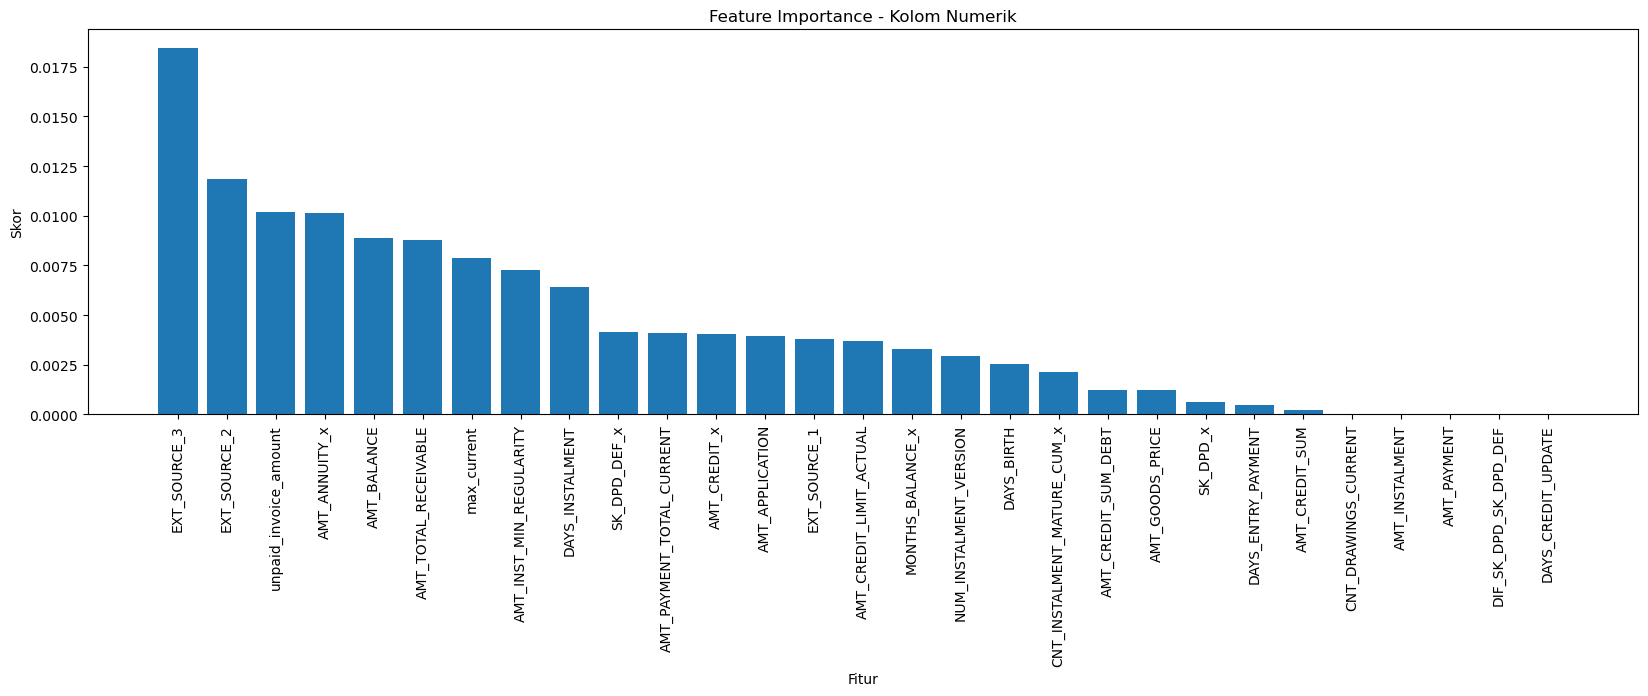

In [113]:
selector_numeric = SelectKBest(score_func=mutual_info_regression, k=29)

# Fit dan transform untuk numerik
selected_numeric_features = selector_numeric.fit_transform(num[num.columns], merged_df['TARGET'])
selected_numeric_indices = selector_numeric.get_support(indices=True)
selected_numeric_columns = num.columns[selected_numeric_indices]

# Simpan skor dan nama fitur numerik dalam DataFrame
numeric_scores = pd.DataFrame({'Feature': selected_numeric_columns,
                               'Score': selector_numeric.scores_})

# Sortir DataFrame berdasarkan skor secara menurun
numeric_scores = numeric_scores.sort_values(by='Score', ascending=False)

# Tampilkan tabel dengan menggunakan pandas
print("Feature Importance untuk Kolom Numerik:")
print(numeric_scores)

# Plot tabel menggunakan matplotlib
plt.figure(figsize=(20, 5))
plt.bar(numeric_scores['Feature'], numeric_scores['Score'])
plt.title('Feature Importance - Kolom Numerik')
plt.xlabel('Fitur')
plt.ylabel('Skor')
plt.xticks(rotation=90)
plt.show()


drop :
CNT_DRAWINGS_CURRENT
DAYS_ENTRY_PAYMENT
AMT_CREDIT_SUM_DEBT
SK_DPD_x
DAYS_CREDIT_UPDATE
MONTHS_BALANCE_x
DIF_SK_DPD_SK_DPD_DEF 
AMT_CREDIT_SUM 
SK_DPD_DEF_x 
NUM_INSTALMENT_VERSION 
AMT_INSTALMENT 
AMT_PAYMENT 

In [114]:
drop = ['CNT_DRAWINGS_CURRENT','DAYS_ENTRY_PAYMENT','AMT_CREDIT_SUM_DEBT','SK_DPD_x','DAYS_CREDIT_UPDATE','MONTHS_BALANCE_x','DIF_SK_DPD_SK_DPD_DEF',
        'AMT_CREDIT_SUM','SK_DPD_DEF_x','NUM_INSTALMENT_VERSION','AMT_INSTALMENT','AMT_PAYMENT']

merged_df = merged_df.drop(drop, axis =1)

# Feature Enginering

In [115]:
cat = create_categorical_dataset(merged_df)
cat

num = create_numeric_dataset(merged_df)
num

,SK_ID_CURR,TARGET,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_ANNUITY_x,AMT_CREDIT_x,AMT_GOODS_PRICE,CNT_INSTALMENT_MATURE_CUM_x,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,max_current,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_TOTAL_RECEIVABLE,unpaid_invoice_amount,DAYS_INSTALMENT,AMT_APPLICATION
0,100011,0,-20099,0.587334,0.205747,0.751724,33826.5,1019610.0,913500.0,33.0,0.000,90000,90000.000,0.00,0.0,0.00,0.00,2237.0,810931.5
1,100023,0,-11348,NaN,0.586617,0.477649,17563.5,544491.0,454500.0,0.0,0.000,225000,225000.000,0.00,0.0,0.00,0.00,2363.0,394987.5
2,100036,0,-11144,0.274422,0.627300,NaN,25033.5,512064.0,360000.0,0.0,0.000,90000,90000.000,0.00,0.0,0.00,0.00,365.0,668106.0
3,100043,0,-17199,0.842763,0.681699,0.754406,23157.0,641173.5,553500.0,20.0,0.000,22500,22500.000,0.00,0.0,0.00,0.00,1039.0,4760775.0
4,100047,1,-17482,NaN,0.306841,0.320163,35028.0,1193580.0,855000.0,0.0,0.000,45000,45000.000,0.00,0.0,0.00,0.00,2481.0,1298205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72788,456241,0,-16679,0.251096,0.651306,0.524496,12028.5,270126.0,193500.0,0.0,0.000,45000,45000.000,0.00,0.0,0.00,0.00,1281.0,1504345.5
72789,456242,0,-19102,NaN,0.746259,0.406617,52168.5,1312110.0,1125000.0,7.0,208711.890,225000,433711.890,11005.56,15804.0,208711.89,192907.89,703.0,397764.0
72790,456244,0,-20390,0.896042,0.789389,0.337673,35982.0,1303812.0,1138500.0,17.0,0.000,0,0.000,0.00,0.0,0.00,0.00,1164.0,2461500.0
72791,456246,0,-16063,NaN,0.313334,0.735221,10620.0,225000.0,225000.0,7.0,62.685,135000,135062.685,130.50,0.0,62.19,62.19,200.0,36031.5


In [116]:
for col in num:
    mean_value = merged_df[col].mean()
    merged_df[col].fillna(mean_value, inplace=True)
    
for col in cat:
    mode_value = merged_df[col].mode()[0]
    merged_df[col].fillna(mode_value, inplace=True)

In [117]:
merged_df.isnull().sum()

SK_ID_CURR                     0
TARGET                         0
ORGANIZATION_TYPE              0
NAME_INCOME_TYPE               0
HOUSETYPE_MODE                 0
CODE_GENDER                    0
NAME_EDUCATION_TYPE            0
REG_CITY_NOT_WORK_CITY         0
DAYS_BIRTH                     0
EXT_SOURCE_1                   0
EXT_SOURCE_2                   0
EXT_SOURCE_3                   0
AMT_ANNUITY_x                  0
AMT_CREDIT_x                   0
AMT_GOODS_PRICE                0
CNT_INSTALMENT_MATURE_CUM_x    0
AMT_BALANCE                    0
AMT_CREDIT_LIMIT_ACTUAL        0
max_current                    0
AMT_INST_MIN_REGULARITY        0
AMT_PAYMENT_TOTAL_CURRENT      0
AMT_TOTAL_RECEIVABLE           0
unpaid_invoice_amount          0
DAYS_INSTALMENT                0
AMT_APPLICATION                0
NAME_CONTRACT_STATUS           0
dtype: int64

In [118]:
merged_df['DAYS_BIRTH'] = merged_df['DAYS_BIRTH']/-365

merged_df['credit_downpayment'] = merged_df['AMT_GOODS_PRICE'] - merged_df['AMT_CREDIT_x']
merged_df['credit_goods_price_ratio'] = merged_df['AMT_CREDIT_x']/merged_df['AMT_GOODS_PRICE']
merged_df['credit_annuity_ratio'] = merged_df['AMT_CREDIT_x']/merged_df['AMT_ANNUITY_x']

drop = ['AMT_GOODS_PRICE','AMT_CREDIT_x','AMT_ANNUITY_x']
merged_df = merged_df.drop(drop, axis = 1)

In [119]:
label_col = ['REG_CITY_NOT_WORK_CITY','NAME_EDUCATION_TYPE','CODE_GENDER','ORGANIZATION_TYPE']
label_encoder = LabelEncoder()
for col in label_col:
    merged_df[col] = label_encoder.fit_transform(merged_df[col])
    label_names = label_encoder.classes_  # Mendapatkan nama label yang diubah
    print(f"Nama label yang diubah pada kolom {col}:")
    print(label_names)
    print()

Nama label yang diubah pada kolom REG_CITY_NOT_WORK_CITY:
['N' 'Y']

Nama label yang diubah pada kolom NAME_EDUCATION_TYPE:
['Academic degree' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Secondary / secondary special']

Nama label yang diubah pada kolom CODE_GENDER:
['F' 'M']

Nama label yang diubah pada kolom ORGANIZATION_TYPE:
['Advertising' 'Agriculture' 'Bank' 'Business Entity Type 1'
 'Business Entity Type 2' 'Business Entity Type 3' 'Cleaning'
 'Construction' 'Culture' 'Electricity' 'Emergency' 'Government' 'Hotel'
 'Housing' 'Industry: type 1' 'Industry: type 10' 'Industry: type 11'
 'Industry: type 12' 'Industry: type 13' 'Industry: type 2'
 'Industry: type 3' 'Industry: type 4' 'Industry: type 5'
 'Industry: type 6' 'Industry: type 7' 'Industry: type 8'
 'Industry: type 9' 'Insurance' 'Kindergarten' 'Legal Services' 'Medicine'
 'Military' 'Mobile' 'Other' 'Police' 'Postal' 'Realtor' 'Religion'
 'Restaurant' 'School' 'Security' 'Security Ministries' 'Self-employe

_______________________________________________________________________________________________________________________

In [120]:
x = pd.get_dummies(merged_df['NAME_INCOME_TYPE'], prefix = 'INCOME_TYPE_')
y = pd.get_dummies(merged_df['HOUSETYPE_MODE'], prefix = 'HOUSETYPE_')
z = pd.get_dummies(merged_df['NAME_CONTRACT_STATUS'], prefix = 'STATUS')

In [121]:
merged_df = pd.concat([merged_df, x], axis=1)
merged_df = pd.concat([merged_df, y], axis=1)
merged_df = pd.concat([merged_df, z], axis=1)
drop = ['NAME_INCOME_TYPE','HOUSETYPE_MODE','NAME_CONTRACT_STATUS']
merged_df = merged_df.drop(drop, axis = 1)

In [122]:
dataset_train = pd.DataFrame()
# Mengambil nama kolom dalam dataset
merged = merged_df.drop('SK_ID_CURR', axis =1)
columns = merged.columns

# Membuat objek MinMaxScaler
scaler = MinMaxScaler()

# Melakukan normalisasi pada semua kolom
dataset_train[columns] = scaler.fit_transform(merged_df[columns])

In [123]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72793 entries, 0 to 72792
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   TARGET                             72793 non-null  float64
 1   ORGANIZATION_TYPE                  72793 non-null  float64
 2   CODE_GENDER                        72793 non-null  float64
 3   NAME_EDUCATION_TYPE                72793 non-null  float64
 4   REG_CITY_NOT_WORK_CITY             72793 non-null  float64
 5   DAYS_BIRTH                         72793 non-null  float64
 6   EXT_SOURCE_1                       72793 non-null  float64
 7   EXT_SOURCE_2                       72793 non-null  float64
 8   EXT_SOURCE_3                       72793 non-null  float64
 9   CNT_INSTALMENT_MATURE_CUM_x        72793 non-null  float64
 10  AMT_BALANCE                        72793 non-null  float64
 11  AMT_CREDIT_LIMIT_ACTUAL            72793 non-null  flo

In [124]:
dataset_train.duplicated().sum()

0

In [125]:
dataset_train['TARGET'].value_counts()

0.0    66695
1.0     6098
Name: TARGET, dtype: int64

# Modeling

In [126]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    # 
    score = cross_validate(LGBMClassifier(), X, y, cv=5, scoring='roc_auc', return_train_score=True)
    print('roc_auc (crossval train) lgbm: '+ str(score['train_score'].mean()))
    print('roc_auc (crossval test) lgbm: '+ str(score['test_score'].mean()))
    score = cross_validate(LogisticRegression(), X, y, cv=5, scoring='roc_auc', return_train_score=True)
    print('roc_auc (crossval train) lr: '+ str(score['train_score'].mean()))
    print('roc_auc (crossval test) lr: '+ str(score['test_score'].mean()))
    
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [127]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(penalty='l2', C=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('C')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter C - Logistic Regression')
    plt.legend()
    plt.show()

In [128]:
X = dataset_train.drop(columns=['TARGET'])
y = dataset_train['TARGET']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [129]:
from sklearn.linear_model import LogisticRegression # import logistic regression dari sklearn
logreg = LogisticRegression(C=2.833, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) # inisiasi object dengan nama logreg
logreg.fit(X_train, y_train) # fit model regression dari data train
eval_classification(logreg)

Accuracy (Test Set): 0.69
Precision (Test Set): 0.17
Recall (Test Set): 0.69
F1-Score (Test Set): 0.27
roc_auc (test-proba): 0.75
roc_auc (train-proba): 0.75
roc_auc (crossval train) lgbm: 0.8690300326561907
roc_auc (crossval test) lgbm: 0.7565266019321528


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

roc_auc (crossval train) lr: 0.7481682230903467
roc_auc (crossval test) lr: 0.7469620435051302


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [130]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(bagging_fraction=0.6, bagging_freq=4, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=96, min_child_weight=0.001, min_split_gain=0.7,
               n_estimators=180, n_jobs=-1, num_leaves=10, objective=None,
               random_state=123, reg_alpha=0.0001, reg_lambda=0.1,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
lgbm.fit(X_train, y_train)
eval_classification(lgbm)

[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Accuracy (Test Set): 0.92
Precision (Test Set): 0.59
Recall (Test Set): 0.03
F1-Score (Test Set): 0.05
roc_auc (test-proba): 0.77
roc_auc (train-proba): 0.79
roc_auc (crossval train) lgbm: 0.8690300326561907
roc_auc (crossval test) lgbm: 0.7565266019321528


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

roc_auc (crossval train) lr: 0.7481682230903467
roc_auc (crossval test) lr: 0.7469620435051302


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


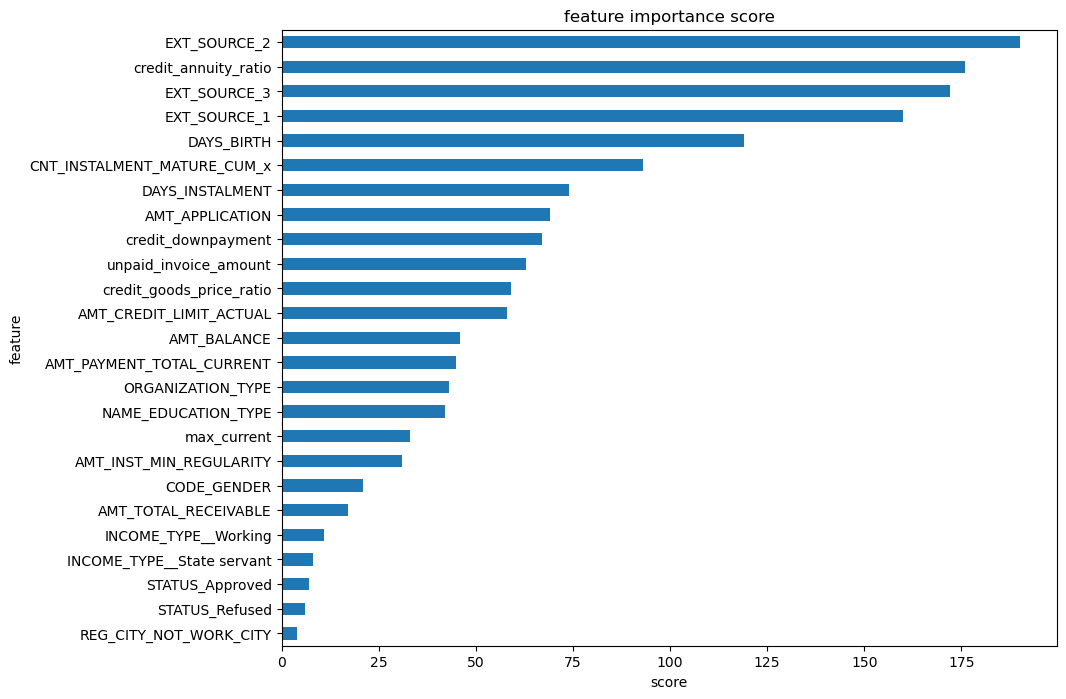

In [131]:
show_feature_importance(lgbm)

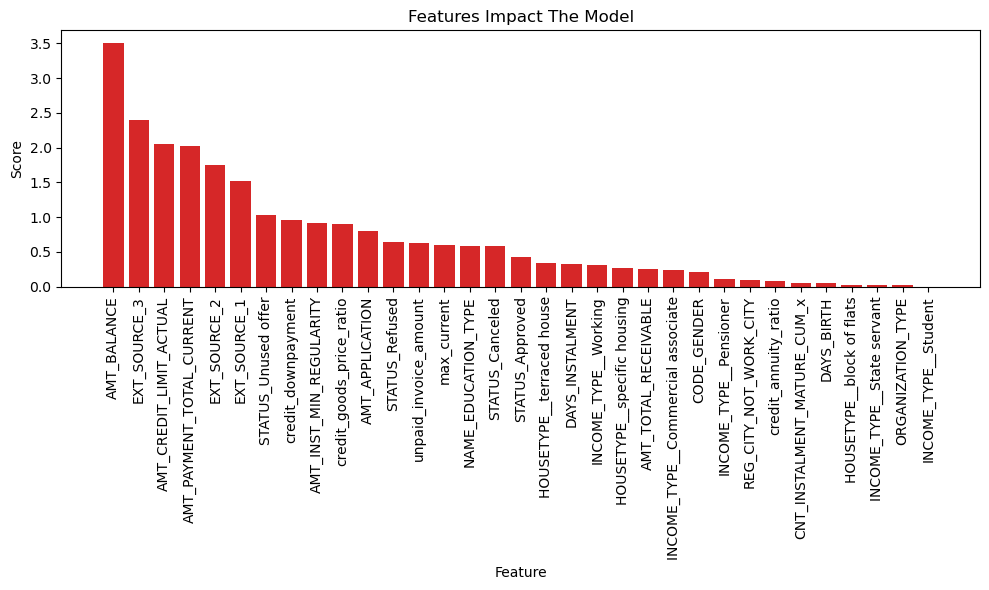

In [132]:
feature_importance = np.abs(logreg.coef_[0])

# Membuat dataframe untuk menampilkan fitur dan kepentingan fitur
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Menampilkan fitur berdasarkan kepentingan fitur secara menurun
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Memplot grafik bar
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color = 'tab:red')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Score')
plt.title('Features Impact The Model')
plt.tight_layout()
plt.show()

# Implementasi

In [133]:
dataset_train['TARGET'].value_counts()

0.0    66695
1.0     6098
Name: TARGET, dtype: int64

In [134]:
testing_lgbm = dataset_train.drop('TARGET', axis = 1)
testing_logreg = dataset_train.drop('TARGET', axis = 1)

In [135]:
testing_lgbm

,ORGANIZATION_TYPE,CODE_GENDER,NAME_EDUCATION_TYPE,REG_CITY_NOT_WORK_CITY,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CNT_INSTALMENT_MATURE_CUM_x,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,max_current,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_TOTAL_RECEIVABLE,unpaid_invoice_amount,DAYS_INSTALMENT,AMT_APPLICATION,credit_downpayment,credit_goods_price_ratio,credit_annuity_ratio,INCOME_TYPE__Commercial associate,INCOME_TYPE__Pensioner,INCOME_TYPE__State servant,INCOME_TYPE__Student,INCOME_TYPE__Working,HOUSETYPE__block of flats,HOUSETYPE__specific housing,HOUSETYPE__terraced house,STATUS_Approved,STATUS_Canceled,STATUS_Refused,STATUS_Unused offer
0,1.000000,0.0,1.00,0.0,0.711609,0.616266,0.240635,0.838874,0.275000,0.000000,0.066667,0.036765,0.000000,0.000000,0.000000,0.539481,0.765170,0.065402,0.390371,0.616595,0.701241,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.491228,0.0,0.25,0.0,0.208678,0.539227,0.686100,0.532810,0.000000,0.000000,0.166667,0.091911,0.000000,0.000000,0.000000,0.539481,0.808365,0.031856,0.408912,0.674294,0.728489,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.754386,0.0,1.00,0.0,0.196954,0.279589,0.733683,0.558463,0.000000,0.000000,0.066667,0.036765,0.000000,0.000000,0.000000,0.539481,0.123414,0.053883,0.337514,0.832494,0.393941,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.578947,0.0,1.00,0.0,0.544943,0.891094,0.797308,0.841869,0.166667,0.000000,0.016667,0.009191,0.000000,0.000000,0.000000,0.539481,0.354474,0.383960,0.411577,0.646375,0.623387,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.087719,1.0,1.00,0.0,0.561207,0.539227,0.358874,0.356943,0.000000,0.000000,0.033333,0.018382,0.000000,0.000000,0.000000,0.539481,0.848817,0.104701,0.122981,0.813882,0.825995,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72788,0.894737,0.0,1.00,1.0,0.515057,0.254492,0.761761,0.585125,0.000000,0.000000,0.033333,0.018382,0.000000,0.000000,0.000000,0.539481,0.437436,0.121327,0.424284,0.813882,0.457449,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
72789,0.122807,1.0,1.00,0.0,0.654310,0.539227,0.872817,0.453488,0.058333,0.172416,0.166667,0.177169,0.185082,0.011811,0.172416,0.617258,0.239287,0.032080,0.297204,0.651959,0.542916,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
72790,0.087719,0.0,0.25,0.0,0.728333,0.948419,0.923262,0.376496,0.141667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.539481,0.397326,0.198522,0.322276,0.637071,0.894518,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
72791,0.684211,0.0,1.00,1.0,0.479655,0.539227,0.366468,0.820445,0.058333,0.000052,0.100000,0.055172,0.002195,0.000000,0.000051,0.539506,0.066850,0.002906,0.512421,0.534705,0.417139,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [136]:
testing_lgbm['testing'] = lgbm.predict(testing_lgbm)
testing_logreg['testing'] = logreg.predict(testing_logreg)

In [137]:
print(testing_lgbm['testing'].value_counts())
print(testing_logreg['testing'].value_counts())

0.0    72498
1.0      295
Name: testing, dtype: int64
0.0    48097
1.0    24696
Name: testing, dtype: int64


In [138]:
testing_lgbm['SK_ID_CURR'] = merged_df['SK_ID_CURR']
testing_logreg['SK_ID_CURR'] = merged_df['SK_ID_CURR']

In [139]:
testing_lgbm = pd.merge(testing_lgbm, installment_payments, on='SK_ID_CURR', how='inner')
testing_logreg = pd.merge(testing_logreg, installment_payments, on='SK_ID_CURR', how='inner')

In [140]:
testing_lgbm

,ORGANIZATION_TYPE,CODE_GENDER,NAME_EDUCATION_TYPE,REG_CITY_NOT_WORK_CITY,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CNT_INSTALMENT_MATURE_CUM_x,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,max_current,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_TOTAL_RECEIVABLE,unpaid_invoice_amount,DAYS_INSTALMENT_x,AMT_APPLICATION,credit_downpayment,credit_goods_price_ratio,credit_annuity_ratio,INCOME_TYPE__Commercial associate,INCOME_TYPE__Pensioner,INCOME_TYPE__State servant,INCOME_TYPE__Student,INCOME_TYPE__Working,HOUSETYPE__block of flats,HOUSETYPE__specific housing,HOUSETYPE__terraced house,STATUS_Approved,STATUS_Canceled,STATUS_Refused,STATUS_Unused offer,testing,SK_ID_CURR,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT_y,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,PAST_DUE
0,1.000000,0.0,1.00,0.0,0.711609,0.616266,0.240635,0.838874,0.275000,0.0,0.066667,0.036765,0.0,0.0,0.0,0.539481,0.765170,0.065402,0.390371,0.616595,0.701241,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100011,1430602,1.0,12,2147.0,1189.0,14588.550,449.685,1
1,1.000000,0.0,1.00,0.0,0.711609,0.616266,0.240635,0.838874,0.275000,0.0,0.066667,0.036765,0.0,0.0,0.0,0.539481,0.765170,0.065402,0.390371,0.616595,0.701241,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100011,2794143,1.0,22,529.0,527.0,31295.250,27193.185,1
2,1.000000,0.0,1.00,0.0,0.711609,0.616266,0.240635,0.838874,0.275000,0.0,0.066667,0.036765,0.0,0.0,0.0,0.539481,0.765170,0.065402,0.390371,0.616595,0.701241,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100011,1843384,0.0,31,1318.0,1321.0,9000.000,9000.000,0
3,1.000000,0.0,1.00,0.0,0.711609,0.616266,0.240635,0.838874,0.275000,0.0,0.066667,0.036765,0.0,0.0,0.0,0.539481,0.765170,0.065402,0.390371,0.616595,0.701241,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100011,2794143,1.0,26,409.0,408.0,31295.250,31295.250,1
4,1.000000,0.0,1.00,0.0,0.711609,0.616266,0.240635,0.838874,0.275000,0.0,0.066667,0.036765,0.0,0.0,0.0,0.539481,0.765170,0.065402,0.390371,0.616595,0.701241,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100011,1843384,0.0,9,1987.0,1996.0,9000.000,9000.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5450841,0.035088,0.0,0.25,0.0,0.238678,0.246282,0.586221,0.679799,0.266667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.539481,0.952005,0.024128,0.399688,0.813882,0.361830,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,456247,1382810,1.0,3,2782.0,2775.0,7544.970,7544.970,1
5450842,0.035088,0.0,0.25,0.0,0.238678,0.246282,0.586221,0.679799,0.266667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.539481,0.952005,0.024128,0.399688,0.813882,0.361830,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,456247,1595171,0.0,99,458.0,458.0,520.605,520.605,0
5450843,0.035088,0.0,0.25,0.0,0.238678,0.246282,0.586221,0.679799,0.266667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.539481,0.952005,0.024128,0.399688,0.813882,0.361830,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,456247,1595171,0.0,68,1403.0,1403.0,520.605,520.605,0
5450844,0.035088,0.0,0.25,0.0,0.238678,0.246282,0.586221,0.679799,0.266667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.539481,0.952005,0.024128,0.399688,0.813882,0.361830,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,456247,1595171,0.0,49,1861.0,1888.0,67.500,67.500,0


In [141]:
testing_logreg

,ORGANIZATION_TYPE,CODE_GENDER,NAME_EDUCATION_TYPE,REG_CITY_NOT_WORK_CITY,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CNT_INSTALMENT_MATURE_CUM_x,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,max_current,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_TOTAL_CURRENT,AMT_TOTAL_RECEIVABLE,unpaid_invoice_amount,DAYS_INSTALMENT_x,AMT_APPLICATION,credit_downpayment,credit_goods_price_ratio,credit_annuity_ratio,INCOME_TYPE__Commercial associate,INCOME_TYPE__Pensioner,INCOME_TYPE__State servant,INCOME_TYPE__Student,INCOME_TYPE__Working,HOUSETYPE__block of flats,HOUSETYPE__specific housing,HOUSETYPE__terraced house,STATUS_Approved,STATUS_Canceled,STATUS_Refused,STATUS_Unused offer,testing,SK_ID_CURR,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT_y,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,PAST_DUE
0,1.000000,0.0,1.00,0.0,0.711609,0.616266,0.240635,0.838874,0.275000,0.0,0.066667,0.036765,0.0,0.0,0.0,0.539481,0.765170,0.065402,0.390371,0.616595,0.701241,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100011,1430602,1.0,12,2147.0,1189.0,14588.550,449.685,1
1,1.000000,0.0,1.00,0.0,0.711609,0.616266,0.240635,0.838874,0.275000,0.0,0.066667,0.036765,0.0,0.0,0.0,0.539481,0.765170,0.065402,0.390371,0.616595,0.701241,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100011,2794143,1.0,22,529.0,527.0,31295.250,27193.185,1
2,1.000000,0.0,1.00,0.0,0.711609,0.616266,0.240635,0.838874,0.275000,0.0,0.066667,0.036765,0.0,0.0,0.0,0.539481,0.765170,0.065402,0.390371,0.616595,0.701241,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100011,1843384,0.0,31,1318.0,1321.0,9000.000,9000.000,0
3,1.000000,0.0,1.00,0.0,0.711609,0.616266,0.240635,0.838874,0.275000,0.0,0.066667,0.036765,0.0,0.0,0.0,0.539481,0.765170,0.065402,0.390371,0.616595,0.701241,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100011,2794143,1.0,26,409.0,408.0,31295.250,31295.250,1
4,1.000000,0.0,1.00,0.0,0.711609,0.616266,0.240635,0.838874,0.275000,0.0,0.066667,0.036765,0.0,0.0,0.0,0.539481,0.765170,0.065402,0.390371,0.616595,0.701241,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100011,1843384,0.0,9,1987.0,1996.0,9000.000,9000.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5450841,0.035088,0.0,0.25,0.0,0.238678,0.246282,0.586221,0.679799,0.266667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.539481,0.952005,0.024128,0.399688,0.813882,0.361830,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,456247,1382810,1.0,3,2782.0,2775.0,7544.970,7544.970,1
5450842,0.035088,0.0,0.25,0.0,0.238678,0.246282,0.586221,0.679799,0.266667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.539481,0.952005,0.024128,0.399688,0.813882,0.361830,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,456247,1595171,0.0,99,458.0,458.0,520.605,520.605,0
5450843,0.035088,0.0,0.25,0.0,0.238678,0.246282,0.586221,0.679799,0.266667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.539481,0.952005,0.024128,0.399688,0.813882,0.361830,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,456247,1595171,0.0,68,1403.0,1403.0,520.605,520.605,0
5450844,0.035088,0.0,0.25,0.0,0.238678,0.246282,0.586221,0.679799,0.266667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.539481,0.952005,0.024128,0.399688,0.813882,0.361830,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,456247,1595171,0.0,49,1861.0,1888.0,67.500,67.500,0


# Prediksi total kerugian dan total customer gagal bayar

In [142]:
true_logreg = testing_logreg[testing_logreg['testing']==1]
true_lgbm = testing_lgbm[testing_lgbm['testing']==1]

In [143]:
print(true_logreg['testing'].value_counts())
print(true_lgbm['testing'].value_counts())

1.0    1736912
Name: testing, dtype: int64
1.0    15945
Name: testing, dtype: int64


In [144]:
total_unpaid_test_logreg = true_logreg[true_logreg['DAYS_ENTRY_PAYMENT']==0].agg({'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()
total_unpaid_test_lgbm = true_lgbm[true_lgbm['DAYS_ENTRY_PAYMENT']==0].agg({'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()
print(total_unpaid_test_logreg)
print()
print(total_unpaid_test_lgbm)

            index           0
0  AMT_INSTALMENT  2574634.68
1     AMT_PAYMENT        0.00

            index         0
0  AMT_INSTALMENT  43259.76
1     AMT_PAYMENT      0.00


In [145]:
inc = ['TARGET','SK_ID_CURR']
application_train_total_unpaid_real = pd.merge(application_train[inc], installment_payments, on='SK_ID_CURR', how='inner')

In [146]:
real = application_train_total_unpaid_real[application_train_total_unpaid_real['TARGET']==1]

In [147]:
total_unpaid_real = real[real['DAYS_ENTRY_PAYMENT']==0].agg({'AMT_INSTALMENT': 'sum', 'AMT_PAYMENT': 'sum'}).reset_index()
total_unpaid_real

,index,0
0,AMT_INSTALMENT,12557193.66
1,AMT_PAYMENT,0.00


In [148]:
count_unpaid_test_logreg = true_logreg[true_logreg['DAYS_ENTRY_PAYMENT']==0].agg({'AMT_INSTALMENT': 'count'}).reset_index()
count_unpaid_test_lgbm = true_lgbm[true_lgbm['DAYS_ENTRY_PAYMENT']==0].agg({'AMT_INSTALMENT': 'count'}).reset_index()
print(count_unpaid_test_logreg)
print()
print(count_unpaid_test_lgbm)

            index    0
0  AMT_INSTALMENT  393

            index  0
0  AMT_INSTALMENT  6


In [149]:
count_unpaid_real = real[real['DAYS_ENTRY_PAYMENT']==0].agg({'AMT_INSTALMENT': 'count', 'AMT_PAYMENT': 'count'}).reset_index()
count_unpaid_real.reset_index()

,level_0,index,0
0,0,AMT_INSTALMENT,592
1,1,AMT_PAYMENT,592
